# Decision Trees e Random Forest

Este notebook implementa e compara modelos de **Decision Trees** e **Random Forest** para classificação de `target_class` (3 classes).

**Objetivos:**
1. **Decision Trees**: Construir modelo base e otimizar hiperparâmetros
2. **Random Forest**: Construir modelo base e otimizar hiperparâmetros
3. **Feature Importance**: Analisar importância das features no Random Forest
4. **Correlação**: Comparar resultados com análises anteriores (EDA, Lasso/Ridge)

**Nota**: Utilizamos os preditores mais relevantes identificados na Task 5 (Feature Selection com L1/Lasso, C=1.0).

In [2]:
# Importação de bibliotecas essenciais para modelação e visualização
# pandas e numpy: manipulação de dados
# matplotlib e seaborn: visualização gráfica
# sklearn: modelos de Machine Learning (Decision Trees, Random Forest, métricas)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from scipy.stats import spearmanr

# Configuração visual para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

## 1. Preparação dos Dados

Aplicamos o mesmo pre-processamento dos notebooks anteriores e utilizamos as features selecionadas pelo método L1 (Lasso) com C=1.0.

In [3]:
# Carregamento do dataset já preprocessado
# O preprocessing foi centralizado em Data/create_preprocessed_data.py
# Inclui: correção focus_factor, consolidação duration, remoção de features problemáticas
df = pd.read_csv('../Data/group_3_preprocessed.csv')

In [4]:
# Separação das features (X) e da variável target (y)
# X contém todas as colunas exceto target_class (target_regression já foi removida)
# y contém a classe a prever (target_class)
X = df.drop(columns=['target_class'])
y = df['target_class']

# Encoding do target: conversão das classes categóricas para valores numéricos
# LabelEncoder atribui um número inteiro a cada classe única
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Classes: {le.classes_}")

# Divisão dos dados em conjuntos de treino (80%) e teste (20%)
# stratify=y_encoded garante que a proporção das classes é mantida em ambos os conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Treino: {len(X_train)} amostras | Teste: {len(X_test)} amostras")

Classes: ['class_13' 'class_74' 'class_78']
Treino: 2400 amostras | Teste: 600 amostras


In [5]:
# Seleção de features utilizando regularização L1 (Lasso)
# 
# Regularização L1 (Lasso):
# - Adiciona penalização |coef| à função de custo
# - Força coeficientes de features pouco importantes a ZERO
# - Realiza seleção automática de features
#
# Parâmetro C (inverso da força de regularização):
# - C pequeno = regularização forte = menos features selecionadas
# - C grande = regularização fraca = mais features mantidas
# - C=1.0: valor equilibrado

# penalty='l1': usa regularização L1 (Lasso)
# solver='saga': algoritmo que suporta L1 em classificação multiclasse
# max_iter=5000: número máximo de iterações para convergência
l1_model = LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=5000, random_state=42)
l1_model.fit(X, y_encoded)

# Identificar features com coeficientes não nulos
# l1_model.coef_: matriz (n_classes x n_features) com os coeficientes
# coef != 0: identifica features que o L1 não zerou
# any(axis=0): True se alguma classe usa a feature (coef != 0)
selected_mask = (l1_model.coef_ != 0).any(axis=0)

# Extrair nomes das features selecionadas
selected_features = X.columns[selected_mask].tolist()

print(f"Features selecionadas pelo L1: {len(selected_features)} de {X.shape[1]}")
print(f"Features: {selected_features}")

Features selecionadas pelo L1: 27 de 38
Features: ['loudness_level', 'popularity_level', 'tempo_class', 'key_mode', 'artist_song_count', 'album_freq', 'movement_index', 'verbal_density', 'purity_score', 'positivity_index', 'activity_rate', 'loudness_intensity', 'happy_dance', 'acoustics_instrumental', 'artists_avg_popularity', 'tempo_vs_genre', 'energy_rank_pct', 'mood_cluster', 'acoustic_valence_mood_cluster', 'explicit', 'mode_indicator', 'focus_factor', 'key_cos', 'duration_log_z', 'resonance_factor', 'distorted_movement', 'duration']


In [6]:
# Criação dos conjuntos de treino e teste apenas com as features selecionadas
# Utilizamos apenas as features identificadas como relevantes pelo L1
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

print(f"Dimensão após seleção: {X_train_sel.shape[1]} features")

Dimensão após seleção: 27 features


---
## 2. Decision Trees

### 2.1. Modelo Base (Sem Otimização)

Construimos uma Decision Tree com parâmetros default do scikit-learn para estabelecer uma baseline de performance.

In [7]:
# Criação da Decision Tree com parâmetros default (sem otimização)
# DecisionTreeClassifier(): cria uma árvore de decisão para classificação
# random_state=42: garante reprodutibilidade dos resultados
dt_base = DecisionTreeClassifier(random_state=42)

# fit(): treina o modelo usando os dados de treino
# O algoritmo aprende regras de decisão baseadas nas features para prever a classe
dt_base.fit(X_train_sel, y_train)

# predict(): aplica as regras aprendidas para fazer previsões
# Retorna um array com a classe prevista para cada amostra
y_train_pred = dt_base.predict(X_train_sel)
y_test_pred = dt_base.predict(X_test_sel)

# accuracy_score(): calcula a proporção de previsões corretas
# accuracy = número de acertos / número total de amostras
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

# Error Rate: complemento da accuracy (proporção de erros)
# error_rate = 1 - accuracy = número de erros / número total de amostras
error_rate = 1 - acc_test

print("=" * 50)
print("DECISION TREE - MODELO BASE (sem otimização)")
print("=" * 50)
print(f"Accuracy Treino: {acc_train:.4f} ({acc_train*100:.2f}%)")
print(f"Accuracy Teste:  {acc_test:.4f} ({acc_test*100:.2f}%)")
print(f"Error Rate:      {error_rate:.4f} ({error_rate*100:.2f}%)")

# Gap: diferença entre accuracy de treino e teste
# Um gap elevado indica overfitting (modelo memoriza treino mas não generaliza)
print(f"Gap (overfit):   {(acc_train - acc_test)*100:.2f}%")

# get_depth(): retorna a profundidade máxima da árvore (número de níveis)
# Árvores muito profundas tendem a fazer overfitting
print(f"Profundidade:    {dt_base.get_depth()}")

# get_n_leaves(): retorna o número de nós terminais (folhas)
# Mais folhas = regras mais específicas = maior risco de overfitting
print(f"Folhas:          {dt_base.get_n_leaves()}")
print()

# classification_report(): mostra precision, recall e f1-score por classe
# Precision: dos que previ como X, quantos são realmente X?
# Recall: dos que são X, quantos consegui identificar?
# F1-score: média harmónica entre precision e recall
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

DECISION TREE - MODELO BASE (sem otimização)
Accuracy Treino: 1.0000 (100.00%)
Accuracy Teste:  0.9050 (90.50%)
Error Rate:      0.0950 (9.50%)
Gap (overfit):   9.50%
Profundidade:    16
Folhas:          157

Classification Report:
              precision    recall  f1-score   support

    class_13       0.88      0.87      0.87       200
    class_74       0.93      0.95      0.94       200
    class_78       0.91      0.90      0.90       200

    accuracy                           0.91       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.91      0.90       600



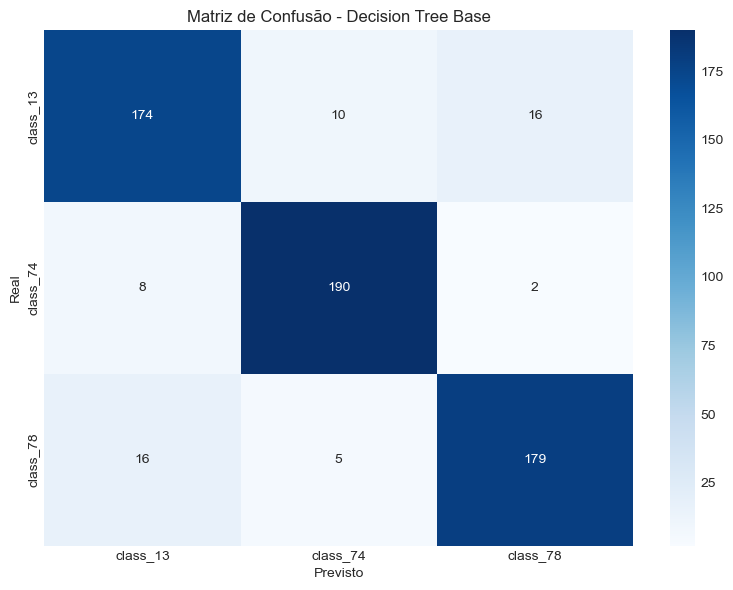

In [8]:
# Matriz de Confusão para o modelo base
# Mostra a distribuição das previsões vs valores reais para cada classe
#
# Interpretação (para cada célula [i,j]):
# - Linha i = classe real
# - Coluna j = classe prevista
# - Diagonal = previsões corretas (True Positives por classe)
# - Fora da diagonal = erros (confusões entre classes)

fig, ax = plt.subplots(figsize=(8, 6))

# confusion_matrix(): cria matriz n_classes x n_classes
cm = confusion_matrix(y_test, y_test_pred)

# heatmap(): visualização com cores (mais escuro = mais amostras)
# annot=True: mostra valores numéricos nas células
# fmt='d': formato inteiro (contagem)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_xlabel('Previsto')
ax.set_ylabel('Real')
ax.set_title('Matriz de Confusão - Decision Tree Base')
plt.tight_layout()
plt.show()

In [9]:
# Representação textual da árvore usando export_text
# Mostra as regras de decisão de forma legível e interpretável
#
# Formato da saída:
# |--- feature <= valor: condição do split
# |   |--- classe: 0: nó folha com classe prevista
# 
# Vantagens:
# - Interpretabilidade: podemos explicar cada decisão
# - Debug: identificar regras problemáticas
# - Comunicação: explicar modelo a stakeholders não técnicos

# max_depth=5: limita a 5 níveis para não sobrecarregar output
tree_rules = export_text(dt_base, feature_names=selected_features, max_depth=5)
print("Regras da Decision Tree (primeiros 5 níveis):")
print(tree_rules)

Regras da Decision Tree (primeiros 5 níveis):
|--- purity_score <= -0.77
|   |--- artist_song_count <= 2.59
|   |   |--- verbal_density <= -0.36
|   |   |   |--- artists_avg_popularity <= 0.63
|   |   |   |   |--- artist_song_count <= 0.27
|   |   |   |   |   |--- happy_dance <= -0.43
|   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |--- happy_dance >  -0.43
|   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |--- artist_song_count >  0.27
|   |   |   |   |   |--- class: 2
|   |   |   |--- artists_avg_popularity >  0.63
|   |   |   |   |--- movement_index <= 0.32
|   |   |   |   |   |--- movement_index <= -1.91
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- movement_index >  -1.91
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- movement_index >  0.32
|   |   |   |   |   |--- class: 0
|   |   |--- verbal_density >  -0.36
|   |   |   |--- duration_log_z <= 0.94
|   |   |   |   |--- movement_index <= 0.66
|   |   

### Análise do Modelo Base

O modelo base apresenta **sinais claros de overfitting**:

| Métrica | Valor | Observação |
|---------|-------|------------|
| Accuracy Treino | 100.00% | Memoriza completamente os dados |
| Accuracy Teste | 90.50% | Performance real |
| Error Rate Teste | 9.50% | Taxa de erro significativa |
| Gap | 9.50% | Overfitting severo |
| Profundidade | 16 | Árvore muito profunda |
| Folhas | 157 | Demasiados nós terminais |

**Interpretação das regras (export_text):**
- A raiz usa `purity_score` como primeiro split, separando músicas com alta energia (baixo purity) das restantes
- O segundo nível usa features como `artist_song_count`, `verbal_density` e `movement_index`
- A árvore é demasiado profunda (16 níveis) para apenas 3 classes

**Conclusão**: A árvore sem restrições cresce até memorizar completamente os dados de treino (100%), mas generaliza mal para dados novos. É necessário aplicar regularização através de hiperparâmetros.

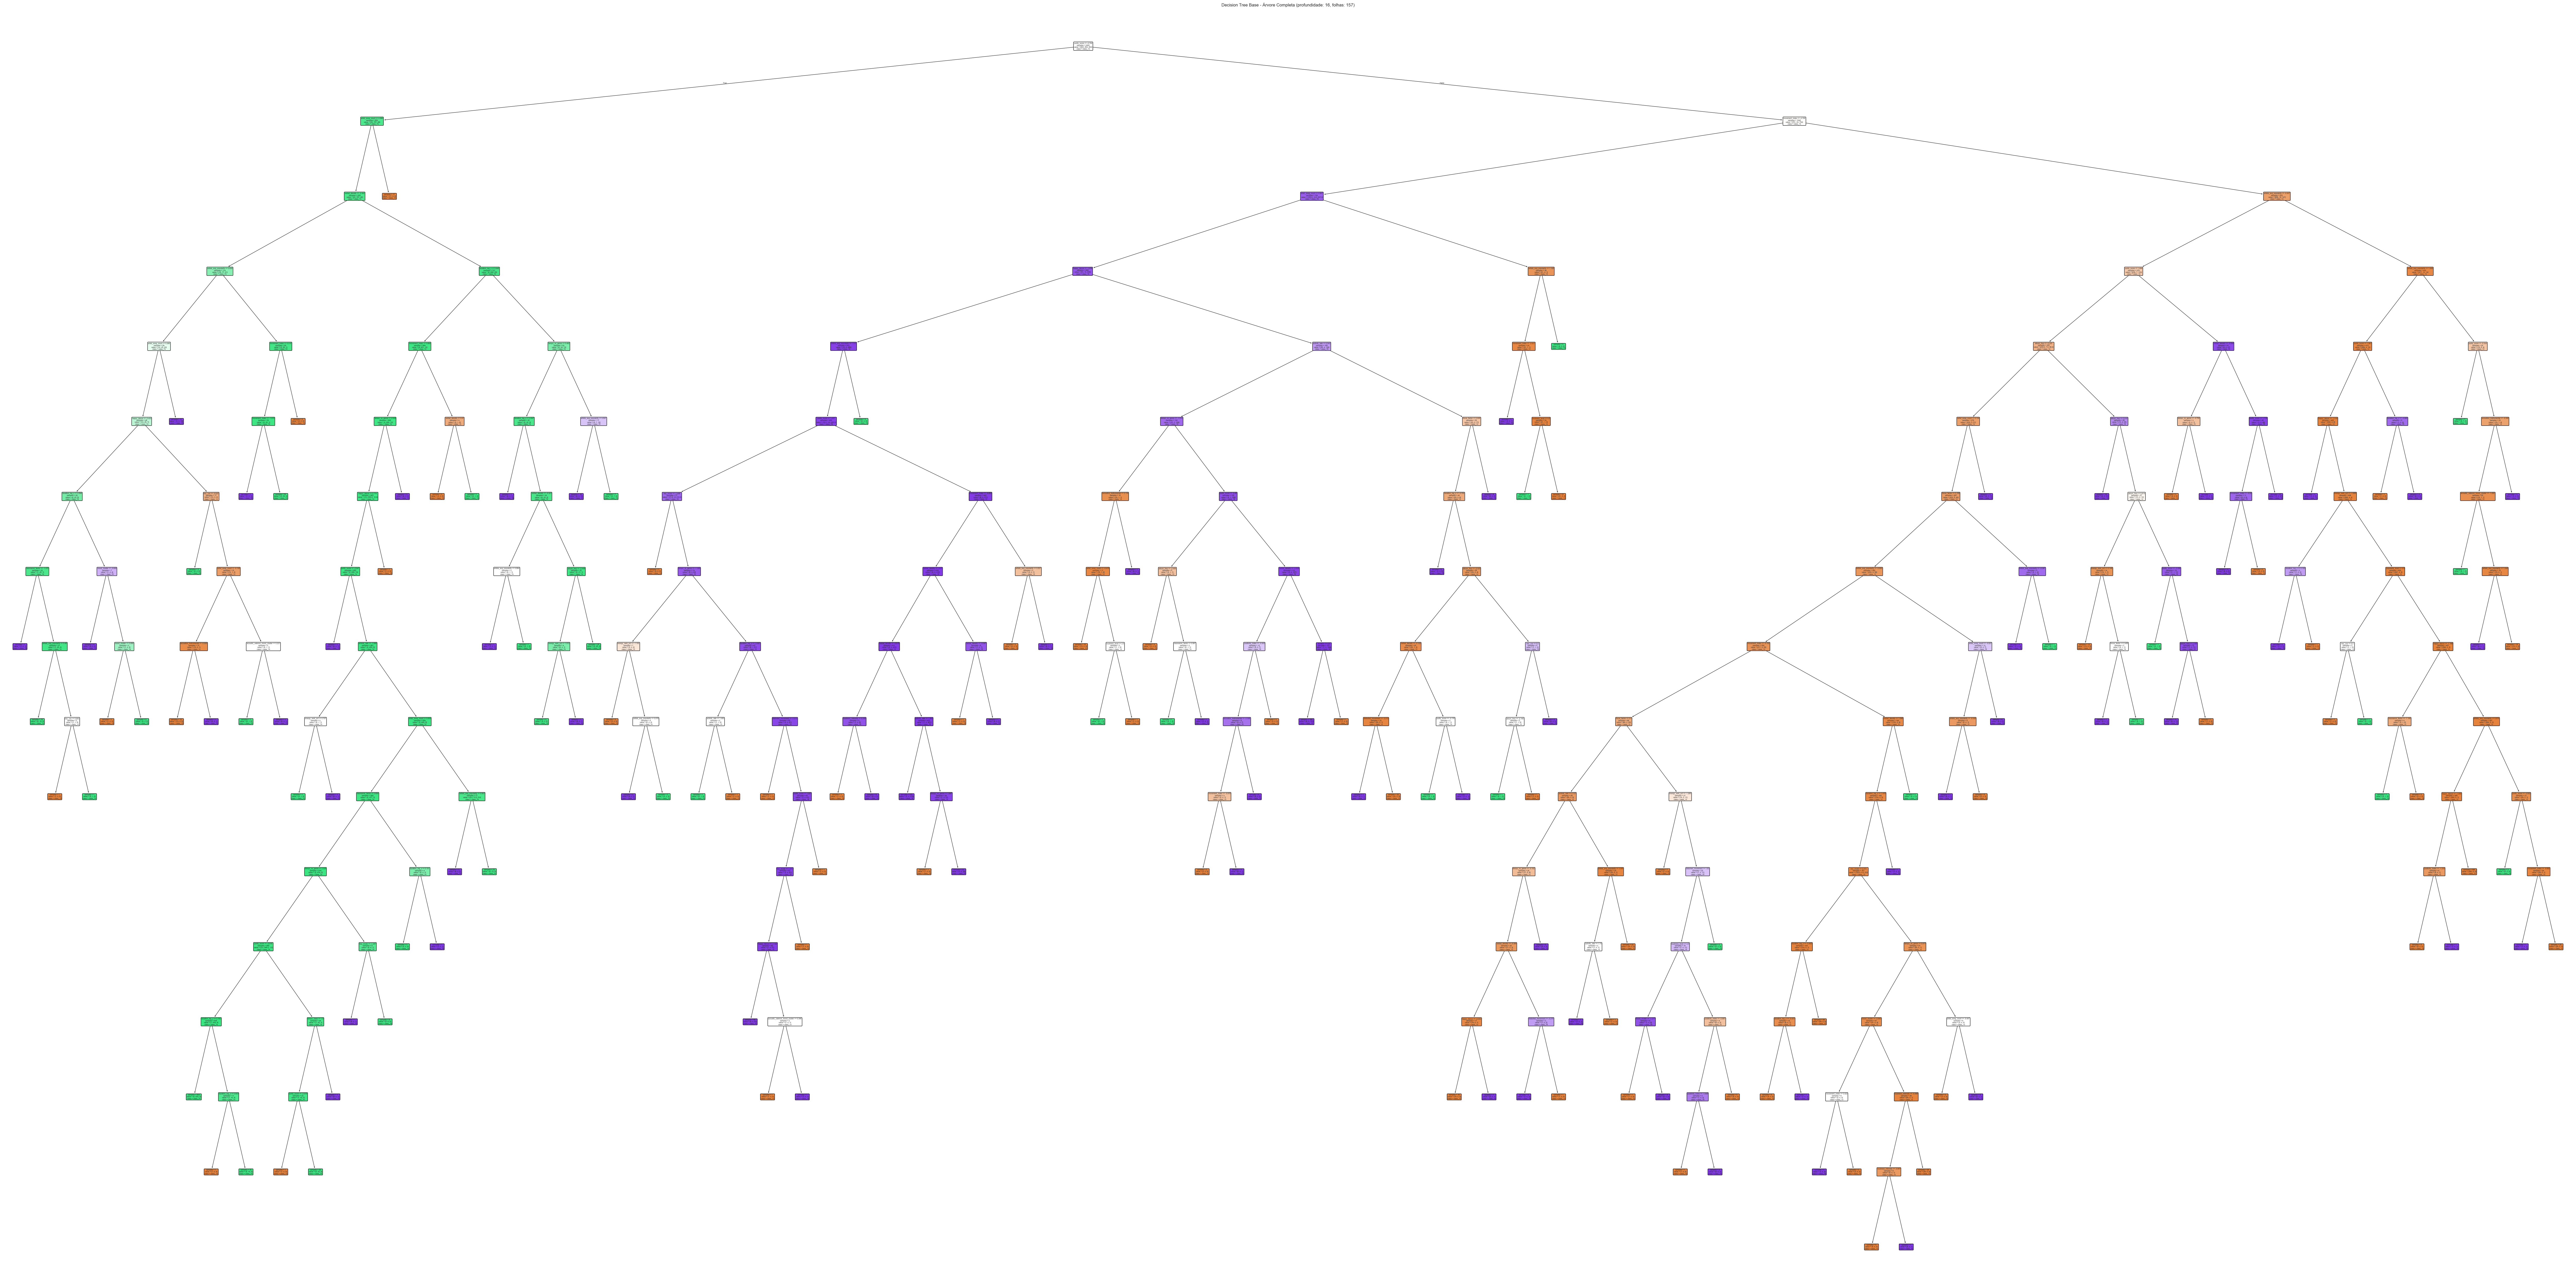

In [10]:
# Visualização gráfica da árvore de decisão completa
# filled=True colore os nós conforme a classe maioritária
# rounded=True usa cantos arredondados para melhor estética
fig, ax = plt.subplots(figsize=(100, 50))
plot_tree(dt_base, feature_names=selected_features,
          class_names=le.classes_, filled=True, rounded=True,
          fontsize=5, ax=ax, impurity=False)
ax.set_title(f"Decision Tree Base - Árvore Completa (profundidade: {dt_base.get_depth()}, folhas: {dt_base.get_n_leaves()})")
plt.tight_layout()
plt.show()

### 2.2. Análise de Overfitting: Impacto de max_depth

Antes de otimizar, vamos analisar como `max_depth` afeta o trade-off entre treino e teste.

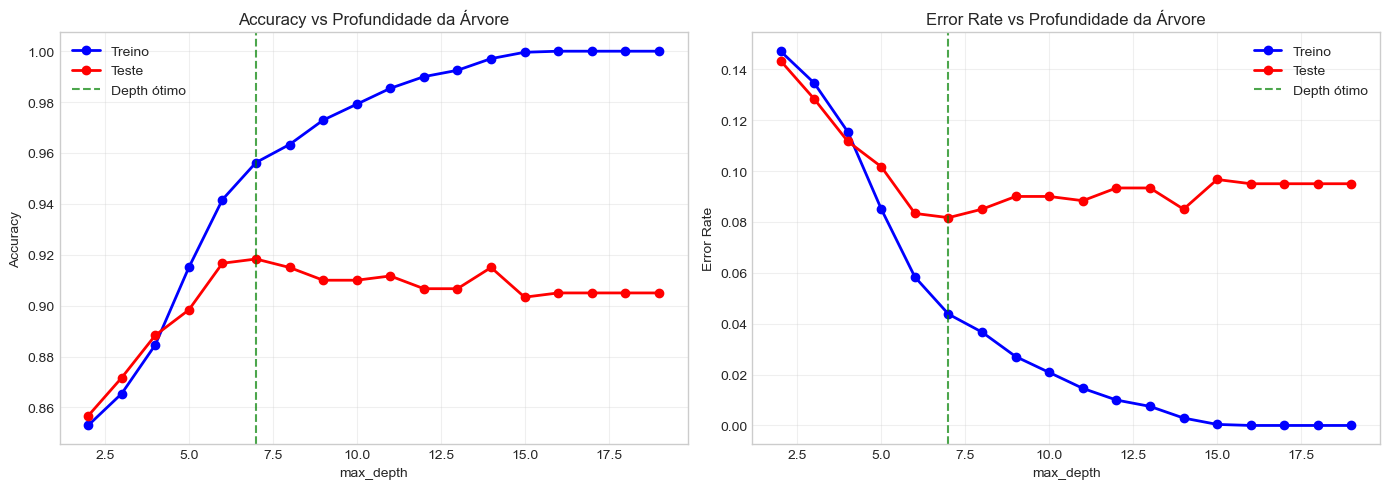

Tabela: Accuracy e Error Rate por Profundidade
-------------------------------------------------------
 Depth    Acc Train     Acc Test   Error Test      Gap
-------------------------------------------------------
     2       85.29%       85.67%       14.33%   -0.38%
     3       86.54%       87.17%       12.83%   -0.63%
     4       88.46%       88.83%       11.17%   -0.37%
     5       91.50%       89.83%       10.17%    1.67%
     6       94.17%       91.67%        8.33%    2.50%
     7       95.62%       91.83%        8.17%    3.79%
     8       96.33%       91.50%        8.50%    4.83%
     9       97.29%       91.00%        9.00%    6.29%
    10       97.92%       91.00%        9.00%    6.92%
    11       98.54%       91.17%        8.83%    7.38%
    12       99.00%       90.67%        9.33%    8.33%
    13       99.25%       90.67%        9.33%    8.58%
    14       99.71%       91.50%        8.50%    8.21%
    15       99.96%       90.33%        9.67%    9.63%
    16      100.

In [11]:
# Análise do impacto de max_depth no trade-off bias-variance
# max_depth limita a profundidade máxima da árvore
# Profundidade baixa = modelo simples = alto bias (underfitting)
# Profundidade alta = modelo complexo = alta variância (overfitting)

depths = range(2, 20)
train_scores = []
test_scores = []

# Treinar uma árvore para cada valor de max_depth
for depth in depths:
    # max_depth=depth: limita a árvore a 'depth' níveis
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train_sel, y_train)
    
    # Guardar accuracy de treino e teste para cada profundidade
    train_scores.append(accuracy_score(y_train, dt.predict(X_train_sel)))
    test_scores.append(accuracy_score(y_test, dt.predict(X_test_sel)))

# Visualização do trade-off bias-variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Accuracy vs Profundidade
# Linha azul (treino) sobe continuamente - mais profundidade = mais memorização
# Linha vermelha (teste) sobe, atinge máximo, depois estagna ou desce
axes[0].plot(depths, train_scores, 'b-o', label='Treino', linewidth=2)
axes[0].plot(depths, test_scores, 'r-o', label='Teste', linewidth=2)
# Linha vertical no ponto ótimo (depth=7) onde teste é máximo
axes[0].axvline(x=7, color='green', linestyle='--', alpha=0.7, label='Depth ótimo')
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy vs Profundidade da Árvore')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Error Rate vs Profundidade
# Error Rate = 1 - Accuracy (complemento)
axes[1].plot(depths, [1-s for s in train_scores], 'b-o', label='Treino', linewidth=2)
axes[1].plot(depths, [1-s for s in test_scores], 'r-o', label='Teste', linewidth=2)
axes[1].axvline(x=7, color='green', linestyle='--', alpha=0.7, label='Depth ótimo')
axes[1].set_xlabel('max_depth')
axes[1].set_ylabel('Error Rate')
axes[1].set_title('Error Rate vs Profundidade da Árvore')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabela detalhada com métricas por profundidade
print("Tabela: Accuracy e Error Rate por Profundidade")
print("-" * 55)
print(f"{'Depth':>6} {'Acc Train':>12} {'Acc Test':>12} {'Error Test':>12} {'Gap':>8}")
print("-" * 55)
for i, depth in enumerate(depths):
    # Gap = diferença entre treino e teste (indica overfitting)
    gap = train_scores[i] - test_scores[i]
    print(f"{depth:>6} {train_scores[i]*100:>11.2f}% {test_scores[i]*100:>11.2f}% {(1-test_scores[i])*100:>11.2f}% {gap*100:>7.2f}%")

### Interpretação da Curva de Overfitting

A análise revela claramente o comportamento de overfitting:

**Zona de Underfitting (depth 2-4):**
- Gap negativo ou muito pequeno
- Modelo demasiado simples, não captura padrões complexos
- Accuracy de teste entre ~85-89%
- Error Rate alto em ambos os conjuntos

**Zona Ótima (depth 5-8):**
- max_depth=6: Treino 94.17%, Teste 91.67%, Gap 2.50%
- max_depth=7: Treino 95.62%, Teste **91.83%** (melhor teste!), Gap 3.79%
- Equilíbrio entre capacidade e generalização
- Error Rate mínimo no teste (~8%)

**Zona de Overfitting (depth >= 12):**
- Accuracy de treino sobe para ~99-100%
- Accuracy de teste diminui para ~90-91%
- Gap cresce significativamente (>8%)
- Error Rate no treino -> 0%, mas Error Rate no teste mantém-se alto (~9-10%)

**Descoberta importante**: O melhor resultado no teste (91.83%) ocorre com max_depth=7, não com a árvore completa (90.50%). Isto demonstra o **trade-off bias-variance**: árvores mais profundas reduzem o bias mas aumentam a variância.

### 2.3. Análise de Cost-Complexity Pruning (ccp_alpha)

O parâmetro `ccp_alpha` controla a poda da árvore baseada em custo-complexidade. Valores maiores resultam em árvores mais podadas (mais simples).

In [12]:
# Cost-Complexity Pruning (Poda por Custo-Complexidade)
# 
# ccp_alpha controla o trade-off entre:
# - Precisão do modelo (menos poda = mais preciso no treino)
# - Complexidade do modelo (mais poda = mais simples)
#
# Fórmula: custo_total = erro + ccp_alpha * número_de_folhas
# - ccp_alpha = 0: sem penalização por complexidade (árvore completa)
# - ccp_alpha grande: penaliza árvores complexas (mais poda)

# cost_complexity_pruning_path(): calcula todos os valores de ccp_alpha
# que produzem uma árvore diferente (pontos de poda)
path = dt_base.cost_complexity_pruning_path(X_train_sel, y_train)
ccp_alphas = path.ccp_alphas  # array com valores de ccp_alpha

print(f"Número de valores de ccp_alpha: {len(ccp_alphas)}")
print(f"Intervalo: [{ccp_alphas.min():.6f}, {ccp_alphas.max():.6f}]")
# ccp_alpha=0: árvore original (sem poda)
# ccp_alpha máximo: árvore com apenas a raiz

Número de valores de ccp_alpha: 103
Intervalo: [0.000000, 0.265342]


In [13]:
# Treino de árvores para diferentes valores de ccp_alpha
# Cada valor produz uma árvore com diferente nível de poda
trees = []
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    dt.fit(X_train_sel, y_train)
    trees.append(dt)

# Cálculo das métricas para cada árvore podada
train_scores_ccp = [accuracy_score(y_train, dt.predict(X_train_sel)) for dt in trees]
test_scores_ccp = [accuracy_score(y_test, dt.predict(X_test_sel)) for dt in trees]
n_nodes = [dt.tree_.node_count for dt in trees]

# Visualização: Accuracy vs ccp_alpha
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(ccp_alphas, train_scores_ccp, 'b-', label='Treino', linewidth=2, marker='.')
axes[0].plot(ccp_alphas, test_scores_ccp, 'r-', label='Teste', linewidth=2, marker='.')
axes[0].set_xlabel('ccp_alpha')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy vs ccp_alpha (Cost-Complexity Pruning)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Identificação do melhor ccp_alpha (maior accuracy no teste)
best_idx = test_scores_ccp.index(max(test_scores_ccp))
best_ccp = ccp_alphas[best_idx]
print(f"Melhor ccp_alpha: {best_ccp:.6f} (Accuracy teste: {test_scores_ccp[best_idx]*100:.2f}%)")

# Visualização: Número de nós vs ccp_alpha
axes[1].plot(ccp_alphas, n_nodes, 'g-', linewidth=2, marker='.')
axes[1].axvline(x=best_ccp, color='red', linestyle='--', alpha=0.7, label=f'Melhor ({best_ccp:.4f})')
axes[1].set_xlabel('ccp_alpha')
axes[1].set_ylabel('Número de Nós')
axes[1].set_title('Complexidade da Árvore vs ccp_alpha')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Melhor ccp_alpha: 0.000799 (Accuracy teste: 92.33%)


### 2.4. Otimização de Hiperparâmetros

Utilizamos Grid Search com validação cruzada (5-fold) para encontrar a combinação ótima de hiperparâmetros. Incluimos:
- `criterion`: gini ou entropy
- `splitter`: best ou random
- `max_depth`, `min_samples_split`, `min_samples_leaf`
- `ccp_alpha`: valores baseados na análise anterior

In [14]:
# Otimização de hiperparâmetros usando Grid Search com Cross-Validation
# GridSearchCV testa todas as combinações de parâmetros e avalia com CV

param_grid = {
    # criterion: função para medir a qualidade de um split
    # 'gini': Gini impurity - probabilidade de classificar errado uma amostra aleatória
    # 'entropy': Ganho de informação - redução da entropia (incerteza) após o split
    'criterion': ['gini', 'entropy'],
    
    # splitter: estratégia para escolher o split em cada nó
    # 'best': escolhe o melhor split (mais lento, mais preciso)
    # 'random': escolhe o melhor split entre um subconjunto aleatório (mais rápido)
    'splitter': ['best', 'random'],
    
    # max_depth: profundidade máxima da árvore (None = sem limite)
    # Valores menores = menos overfitting, mas pode causar underfitting
    'max_depth': [5, 7, 10, 15, None],
    
    # min_samples_split: número mínimo de amostras para dividir um nó interno
    # Valores maiores = árvore mais conservadora
    'min_samples_split': [2, 5, 10],
    
    # min_samples_leaf: número mínimo de amostras em cada folha
    # Valores maiores = folhas mais "puras" mas menos específicas
    'min_samples_leaf': [1, 2, 4],
    
    # ccp_alpha: parâmetro de complexidade para poda (Cost-Complexity Pruning)
    # Valores maiores = mais poda = árvore mais simples
    # 0.0 = sem poda adicional
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01]
}

# GridSearchCV: procura exaustiva de hiperparâmetros
# cv=5: validação cruzada com 5 folds (80% treino, 20% validação, 5 vezes)
# scoring='accuracy': métrica a otimizar
# n_jobs=-1: usa todos os cores do CPU para paralelizar
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# fit(): treina modelos para todas as combinações e guarda os resultados
grid_search.fit(X_train_sel, y_train)

# best_score_: melhor accuracy média nos 5 folds de CV
print(f"Melhor score CV: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")
# best_params_: combinação de parâmetros que obteve o melhor score
print(f"Melhores parâmetros: {grid_search.best_params_}")

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Melhor score CV: 0.9092 (90.92%)
Melhores parâmetros: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}


In [15]:
# Avaliação do modelo otimizado no conjunto de teste
# Utilizamos o melhor modelo encontrado pelo Grid Search
dt_opt = grid_search.best_estimator_

y_train_pred_opt = dt_opt.predict(X_train_sel)
y_test_pred_opt = dt_opt.predict(X_test_sel)

acc_train_opt = accuracy_score(y_train, y_train_pred_opt)
acc_test_opt = accuracy_score(y_test, y_test_pred_opt)
error_rate_opt = 1 - acc_test_opt

print("=" * 50)
print("DECISION TREE - MODELO OTIMIZADO")
print("=" * 50)
print(f"Accuracy Treino: {acc_train_opt:.4f} ({acc_train_opt*100:.2f}%)")
print(f"Accuracy Teste:  {acc_test_opt:.4f} ({acc_test_opt*100:.2f}%)")
print(f"Error Rate:      {error_rate_opt:.4f} ({error_rate_opt*100:.2f}%)")
print(f"Gap (overfit):   {(acc_train_opt - acc_test_opt)*100:.2f}%")
print(f"Profundidade:    {dt_opt.get_depth()}")
print(f"Folhas:          {dt_opt.get_n_leaves()}")
print()
print("Classification Report:")
print(classification_report(y_test, y_test_pred_opt, target_names=le.classes_))

DECISION TREE - MODELO OTIMIZADO
Accuracy Treino: 0.9883 (98.83%)
Accuracy Teste:  0.9167 (91.67%)
Error Rate:      0.0833 (8.33%)
Gap (overfit):   7.17%
Profundidade:    15
Folhas:          120

Classification Report:
              precision    recall  f1-score   support

    class_13       0.91      0.88      0.90       200
    class_74       0.94      0.97      0.96       200
    class_78       0.90      0.90      0.90       200

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



In [16]:
# Representação textual da árvore otimizada
# Permite comparar as regras de decisão com o modelo base
tree_rules_opt = export_text(dt_opt, feature_names=selected_features, max_depth=5)
print("Regras da Decision Tree Otimizada (primeiros 5 níveis):")
print(tree_rules_opt)

Regras da Decision Tree Otimizada (primeiros 5 níveis):
|--- purity_score <= -0.75
|   |--- energy_rank_pct <= 0.64
|   |   |--- artist_song_count <= 2.21
|   |   |   |--- artists_avg_popularity <= 0.90
|   |   |   |   |--- happy_dance <= -0.47
|   |   |   |   |   |--- verbal_density <= -0.51
|   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |--- verbal_density >  -0.51
|   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |--- happy_dance >  -0.47
|   |   |   |   |   |--- distorted_movement <= 0.54
|   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |--- distorted_movement >  0.54
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- artists_avg_popularity >  0.90
|   |   |   |   |--- class: 1
|   |   |--- artist_song_count >  2.21
|   |   |   |--- class: 0
|   |--- energy_rank_pct >  0.64
|   |   |--- artists_avg_popularity <= 0.55
|   |   |   |--- artist_song_count <= 0.64
|   |   |   |   |--- purity_score <= -0

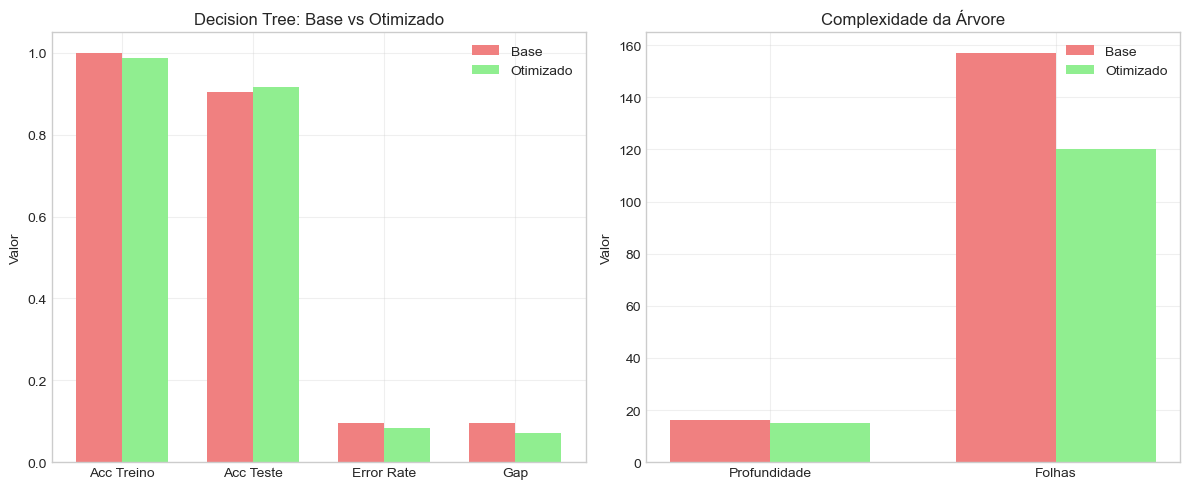

In [17]:
# Comparação visual entre o modelo base e o modelo otimizado
# Permite avaliar o impacto da otimização nas métricas principais
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Métricas do modelo base
metrics_base = [acc_train, acc_test, 1-acc_test, acc_train - acc_test]
labels = ['Acc Treino', 'Acc Teste', 'Error Rate', 'Gap']

# Métricas do modelo otimizado  
metrics_opt = [acc_train_opt, acc_test_opt, 1-acc_test_opt, acc_train_opt - acc_test_opt]

x = np.arange(len(labels))
width = 0.35

axes[0].bar(x - width/2, metrics_base, width, label='Base', color='lightcoral')
axes[0].bar(x + width/2, metrics_opt, width, label='Otimizado', color='lightgreen')
axes[0].set_ylabel('Valor')
axes[0].set_title('Decision Tree: Base vs Otimizado')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Comparação de complexidade: profundidade e número de folhas
complexity = ['Profundidade', 'Folhas']
base_complexity = [dt_base.get_depth(), dt_base.get_n_leaves()]
opt_complexity = [dt_opt.get_depth(), dt_opt.get_n_leaves()]

x2 = np.arange(len(complexity))
axes[1].bar(x2 - width/2, base_complexity, width, label='Base', color='lightcoral')
axes[1].bar(x2 + width/2, opt_complexity, width, label='Otimizado', color='lightgreen')
axes[1].set_ylabel('Valor')
axes[1].set_title('Complexidade da Árvore')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(complexity)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Análise da Otimização - Decision Tree

**Comparação Base vs Otimizado:**

| Métrica | DT Base | DT Otimizado | Melhoria |
|---------|---------|--------------|----------|
| Accuracy Treino | 100.00% | 98.83% | -1.17% (esperado) |
| Accuracy Teste | 90.50% | **91.67%** | **+1.17%** |
| Error Rate Teste | 9.50% | **8.33%** | **-1.17%** |
| Gap | 9.50% | 7.17% | -2.33% |
| Profundidade | 16 | 15 | -1 nível |
| Folhas | 157 | 120 | -37 nós |

**Hiperparâmetros ótimos encontrados:**
- : Usa entropia para medir impureza
- : Escolhe o melhor split (não aleatório)
- : Limita profundidade para controlar overfitting
- : Mínimo 2 amostras para dividir um nó
- : Requer mínimo 2 amostras por folha
- : Sem poda por custo-complexidade

**Observações:**
- A otimização **melhorou a accuracy no teste em 1.17 pontos percentuais**
- O Error Rate foi reduzido de 9.50% para 8.33%
- O gap de overfitting foi reduzido de 9.50% para 7.17% (melhoria de 24.5%)
- O modelo ficou mais simples (120 folhas vs 157) e mais generalizável

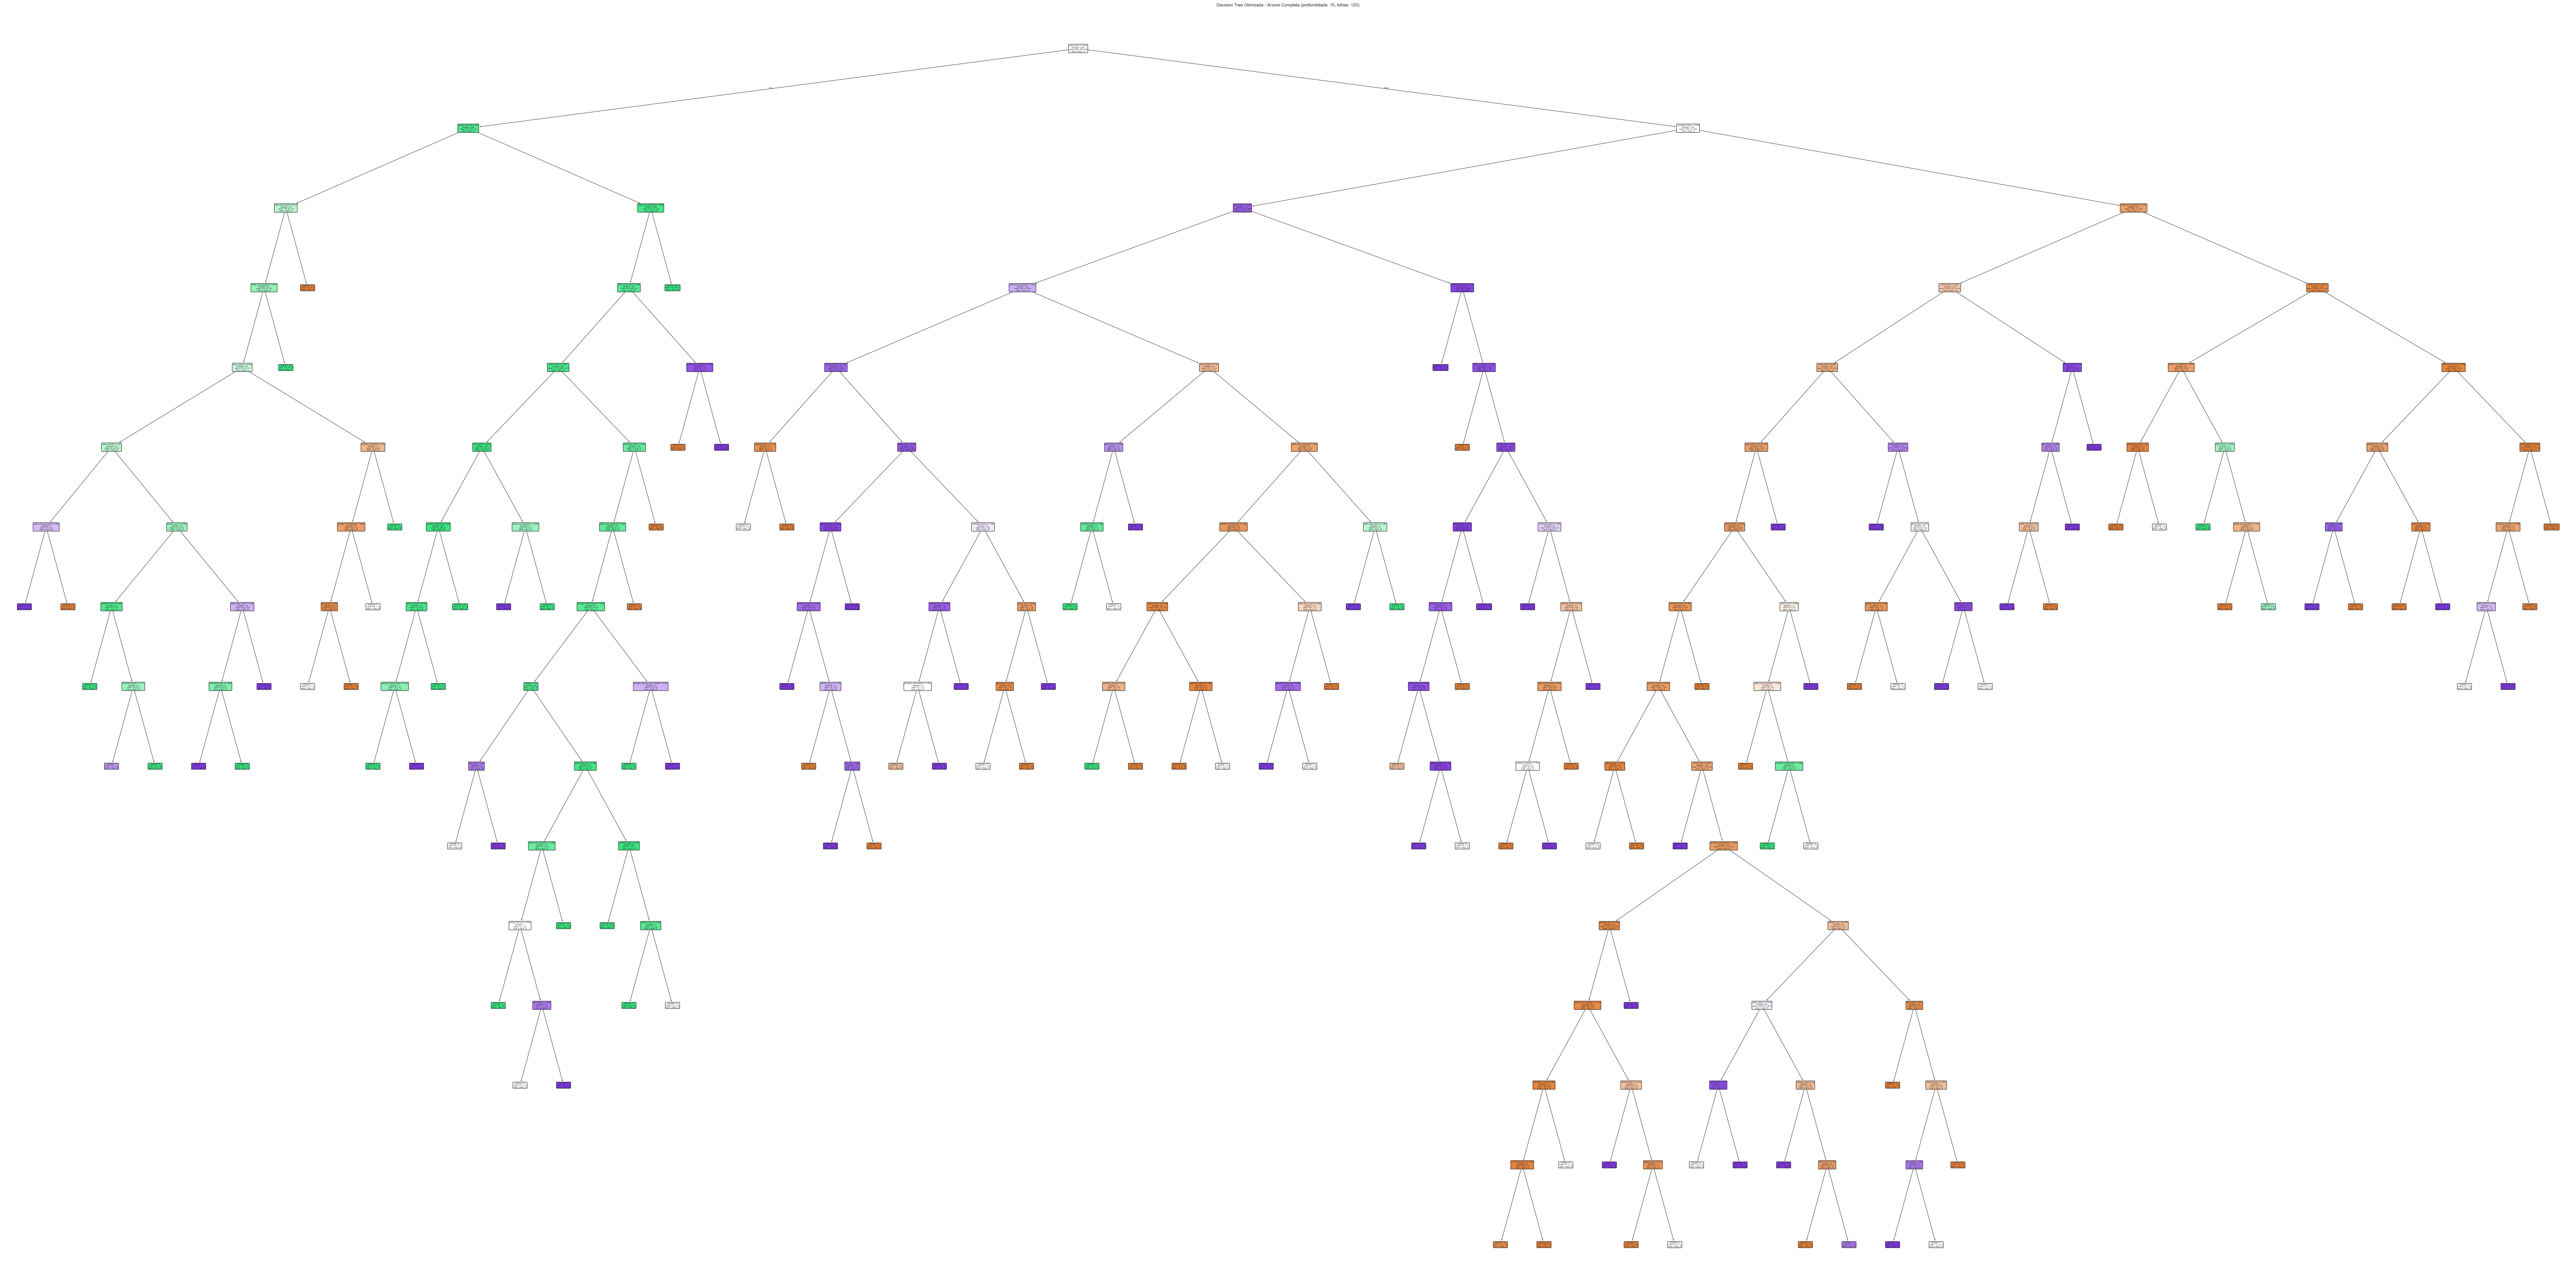

In [18]:
# Visualização gráfica da árvore de decisão otimizada
# Comparar visualmente com a árvore base para ver o efeito da poda
fig, ax = plt.subplots(figsize=(100, 50))
plot_tree(dt_opt, feature_names=selected_features,
          class_names=le.classes_, filled=True, rounded=True,
          fontsize=5, ax=ax, impurity=False)
ax.set_title(f"Decision Tree Otimizada - Árvore Completa (profundidade: {dt_opt.get_depth()}, folhas: {dt_opt.get_n_leaves()})")
plt.tight_layout()
plt.show()

---
## 3. Random Forest

### 3.1. Modelo Base (Sem Otimização)

Random Forest é um ensemble de Decision Trees que combina múltiplas árvores para reduzir variância e overfitting.

In [19]:
# Random Forest: ensemble de múltiplas Decision Trees
# Cada árvore é treinada numa amostra bootstrap (com reposição) dos dados
# A previsão final é a votação maioritária de todas as árvores

# n_estimators=100: número de árvores no ensemble (mais = mais estável, mais lento)
# random_state=42: garante reprodutibilidade
# oob_score=True: calcula o Out-of-Bag score
#   - OOB Score: cada amostra é avaliada apenas pelas árvores que NÃO a usaram no treino
#   - Fornece estimativa de erro sem precisar de conjunto de validação separado
rf_base = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)

# fit(): treina as 100 árvores, cada uma com dados bootstrap diferentes
rf_base.fit(X_train_sel, y_train)

# Previsões: cada árvore vota numa classe, ganha a classe com mais votos
y_train_pred_rf = rf_base.predict(X_train_sel)
y_test_pred_rf = rf_base.predict(X_test_sel)

# Métricas de avaliação
acc_train_rf = accuracy_score(y_train, y_train_pred_rf)
acc_test_rf = accuracy_score(y_test, y_test_pred_rf)
error_rate_rf = 1 - acc_test_rf

print("=" * 50)
print("RANDOM FOREST - MODELO BASE (sem otimização)")
print("=" * 50)
print(f"Accuracy Treino: {acc_train_rf:.4f} ({acc_train_rf*100:.2f}%)")
print(f"Accuracy Teste:  {acc_test_rf:.4f} ({acc_test_rf*100:.2f}%)")
print(f"Error Rate:      {error_rate_rf:.4f} ({error_rate_rf*100:.2f}%)")
print(f"Gap (overfit):   {(acc_train_rf - acc_test_rf)*100:.2f}%")

# oob_score_: accuracy estimada usando apenas amostras out-of-bag
# Se OOB Score ~ Test Accuracy, o modelo generaliza bem
print(f"OOB Score:       {rf_base.oob_score_:.4f} ({rf_base.oob_score_*100:.2f}%)")
print()
print("Classification Report:")
print(classification_report(y_test, y_test_pred_rf, target_names=le.classes_))

RANDOM FOREST - MODELO BASE (sem otimização)
Accuracy Treino: 1.0000 (100.00%)
Accuracy Teste:  0.9533 (95.33%)
Error Rate:      0.0467 (4.67%)
Gap (overfit):   4.67%
OOB Score:       0.9242 (92.42%)

Classification Report:
              precision    recall  f1-score   support

    class_13       0.94      0.94      0.94       200
    class_74       0.96      0.99      0.98       200
    class_78       0.96      0.94      0.95       200

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



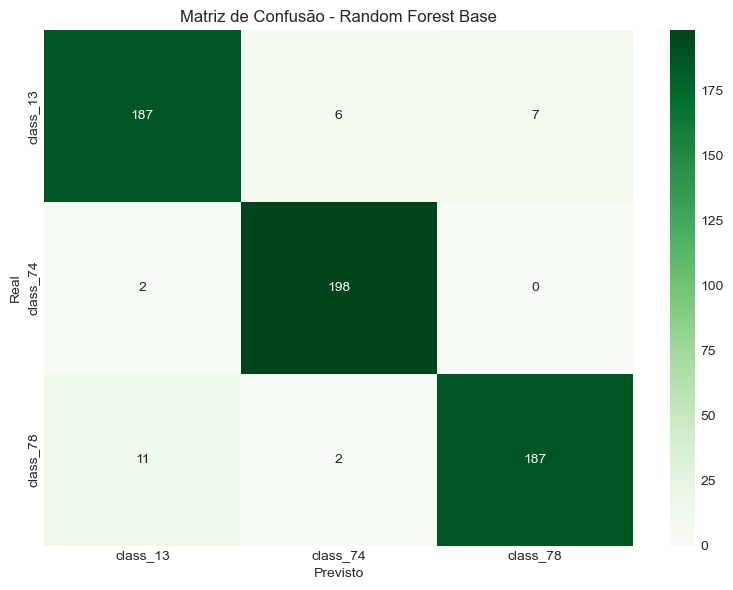

In [20]:
# Visualização da matriz de confusão para o Random Forest base
# Comparar com a matriz do Decision Tree para ver a melhoria
fig, ax = plt.subplots(figsize=(8, 6))
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_xlabel('Previsto')
ax.set_ylabel('Real')
ax.set_title('Matriz de Confusão - Random Forest Base')
plt.tight_layout()
plt.show()

### Análise do Random Forest Base

| Métrica | RF Base | DT Base | Diferença |
|---------|---------|---------|-----------|
| Accuracy Teste | **95.33%** | 90.50% | **+4.83%** |
| Error Rate Teste | **4.67%** | 9.50% | **-4.83%** |
| Gap | 4.67% | 9.50% | -4.83% |
| OOB Score | 92.42% | - | - |

**Observações importantes:**
- O Random Forest obteve uma **melhoria de 4.83 pontos percentuais** no teste face à Decision Tree base
- O Error Rate foi reduzido **para menos de metade** (de 9.50% para 4.67%)
- O gap de overfitting foi também reduzido para menos de metade (4.67% vs 9.50%)
- O **OOB Score (92.42%)** fornece uma estimativa de performance sem necessidade de conjunto de validação separado
- O OOB Score é ligeiramente inferior ao Accuracy Teste, indicando que o modelo não está a sobreajustar

**Performance por classe (classification report):**
- class_13 (dançáveis): ~94% accuracy
- class_74 (energéticas): **~96-99%** accuracy (quase perfeito\!)
- class_78 (acústicas): ~94-96% accuracy

A classe 74 (músicas energéticas) é a mais fácil de classificar, consistente com a análise EDA que identificou features de energia como muito discriminativas.

### 3.2. Bagging vs Random Forest

Comparação entre Bagging (todas as features) e Random Forest (subconjunto aleatório de features por split).

In [21]:
# Comparação entre Bagging e Random Forest
# Ambos são ensembles de árvores, mas diferem na aleatoriedade:

# BAGGING (Bootstrap Aggregating):
# - Cada árvore usa uma amostra bootstrap diferente dos dados
# - Usa TODAS as features em cada split (max_features=None implícito)
# - Árvores são mais correlacionadas (usam as mesmas features dominantes)
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,  # 100 árvores no ensemble
    random_state=42,
    oob_score=True  # Calcula OOB score
)
bagging.fit(X_train_sel, y_train)

# RANDOM FOREST:
# - Também usa amostra bootstrap por árvore
# - Usa apenas um SUBCONJUNTO de features em cada split (max_features='sqrt')
# - sqrt(28) ~ 5 features são consideradas em cada split
# - Árvores são menos correlacionadas = maior diversidade = melhor ensemble
rf_sqrt = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',  # Apenas sqrt(n_features) por split
    random_state=42,
    oob_score=True
)
rf_sqrt.fit(X_train_sel, y_train)

# Previsões de ambos os modelos
y_pred_bag = bagging.predict(X_test_sel)
y_pred_rf_sqrt = rf_sqrt.predict(X_test_sel)

# Cálculo das métricas
acc_bag = accuracy_score(y_test, y_pred_bag)
acc_rf_sqrt = accuracy_score(y_test, y_pred_rf_sqrt)

# Comparação das métricas
print("=" * 60)
print("COMPARAÇÃO: BAGGING vs RANDOM FOREST")
print("=" * 60)
print(f"{'Modelo':<25} {'Acc Teste':>12} {'OOB Score':>12} {'Error Rate':>12}")
print("-" * 60)
print(f"{'Bagging (todas features)':<25} {acc_bag*100:>11.2f}% {bagging.oob_score_*100:>11.2f}% {(1-acc_bag)*100:>11.2f}%")
print(f"{'RF (sqrt features)':<25} {acc_rf_sqrt*100:>11.2f}% {rf_sqrt.oob_score_*100:>11.2f}% {(1-acc_rf_sqrt)*100:>11.2f}%")

# Interpretação:
# RF geralmente supera Bagging porque a aleatoriedade nas features
# reduz a correlação entre árvores, aumentando a diversidade do ensemble

COMPARAÇÃO: BAGGING vs RANDOM FOREST
Modelo                       Acc Teste    OOB Score   Error Rate
------------------------------------------------------------
Bagging (todas features)        94.67%       93.54%        5.33%
RF (sqrt features)              95.33%       92.42%        4.67%


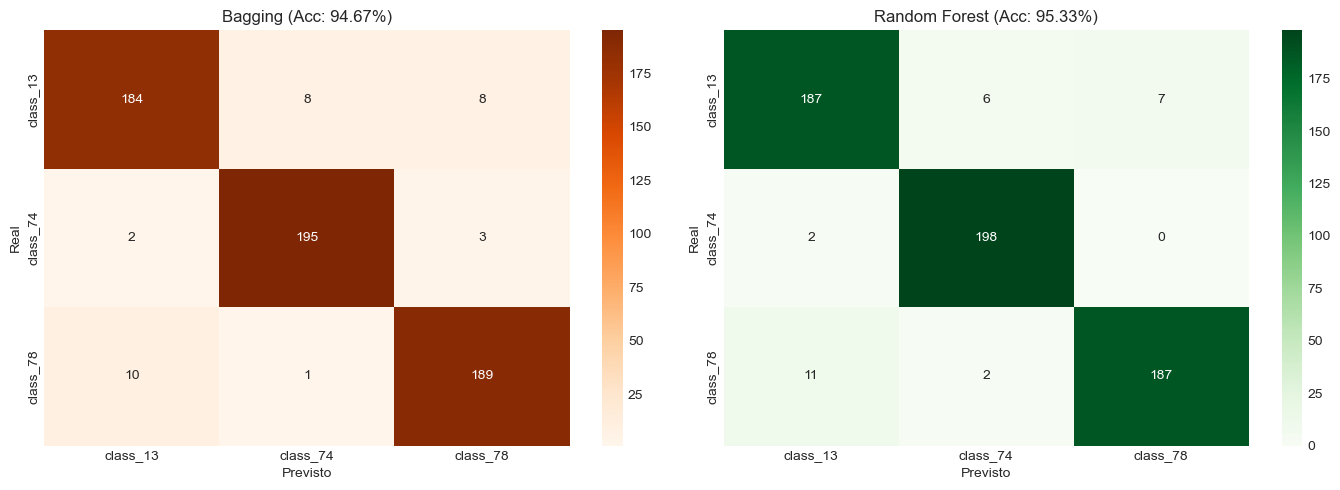

In [22]:
# Visualização comparativa das matrizes de confusão: Bagging vs Random Forest
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_bag = confusion_matrix(y_test, y_pred_bag)
cm_rf = confusion_matrix(y_test, y_pred_rf_sqrt)

sns.heatmap(cm_bag, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title(f'Bagging (Acc: {acc_bag*100:.2f}%)')
axes[0].set_xlabel('Previsto')
axes[0].set_ylabel('Real')

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title(f'Random Forest (Acc: {acc_rf_sqrt*100:.2f}%)')
axes[1].set_xlabel('Previsto')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

### Interpretação: Bagging vs Random Forest

| Modelo | Acc Teste | OOB Score | Error Rate |
|--------|-----------|-----------|------------|
| Bagging (todas features) | 94.67% | 93.54% | 5.33% |
| **RF (sqrt features)** | **95.33%** | 92.42% | **4.67%** |
| Diferença | +0.67% | -1.12% | -0.67% |

**Análise teórica (Bias-Variance Trade-off):**

O **Bagging** usa todas as 27 features em cada split, o que pode levar a:
- Árvores mais correlacionadas entre si (todas usam as mesmas features dominantes)
- Menor redução de variância no ensemble
- OOB Score mais alto porque cada árvore individual é mais forte

O **Random Forest** usa apenas sqrt(27) ~ 5 features por split, o que:
- Cria árvores mais diversas e descorrelacionadas
- Maior redução de variância através da agregação
- Melhor generalização (accuracy teste superior)

**Conclusão:**
- Random Forest (95.33%) supera ligeiramente Bagging (94.67%) no conjunto de teste
- A diferença de 0.67 pontos percentuais demonstra que a aleatoriedade adicional do RF reduz a correlação entre árvores e melhora a generalização
- Apesar do OOB Score do Bagging ser superior (93.54% vs 92.42%), o que importa é a performance no conjunto de teste não visto

### 3.3. Otimização de Hiperparâmetros

In [23]:
# Otimização de hiperparâmetros do Random Forest usando Grid Search
# Testamos diferentes combinações de n_estimators, max_depth, max_features, etc.
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, oob_score=True),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train_sel, y_train)

print(f"Melhor score CV: {grid_search_rf.best_score_:.4f} ({grid_search_rf.best_score_*100:.2f}%)")
print(f"Melhores parâmetros: {grid_search_rf.best_params_}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Melhor score CV: 0.9271 (92.71%)
Melhores parâmetros: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [24]:
# Avaliação do Random Forest otimizado no conjunto de teste
rf_opt = grid_search_rf.best_estimator_

y_train_pred_rf_opt = rf_opt.predict(X_train_sel)
y_test_pred_rf_opt = rf_opt.predict(X_test_sel)

acc_train_rf_opt = accuracy_score(y_train, y_train_pred_rf_opt)
acc_test_rf_opt = accuracy_score(y_test, y_test_pred_rf_opt)
error_rate_rf_opt = 1 - acc_test_rf_opt

print("=" * 50)
print("RANDOM FOREST - MODELO OTIMIZADO")
print("=" * 50)
print(f"Accuracy Treino: {acc_train_rf_opt:.4f} ({acc_train_rf_opt*100:.2f}%)")
print(f"Accuracy Teste:  {acc_test_rf_opt:.4f} ({acc_test_rf_opt*100:.2f}%)")
print(f"Error Rate:      {error_rate_rf_opt:.4f} ({error_rate_rf_opt*100:.2f}%)")
print(f"Gap (overfit):   {(acc_train_rf_opt - acc_test_rf_opt)*100:.2f}%")
print(f"OOB Score:       {rf_opt.oob_score_:.4f} ({rf_opt.oob_score_*100:.2f}%)")
print()
print("Classification Report:")
print(classification_report(y_test, y_test_pred_rf_opt, target_names=le.classes_))

RANDOM FOREST - MODELO OTIMIZADO
Accuracy Treino: 0.9967 (99.67%)
Accuracy Teste:  0.9467 (94.67%)
Error Rate:      0.0533 (5.33%)
Gap (overfit):   5.00%
OOB Score:       0.9263 (92.62%)

Classification Report:
              precision    recall  f1-score   support

    class_13       0.92      0.93      0.93       200
    class_74       0.96      0.98      0.97       200
    class_78       0.96      0.93      0.95       200

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



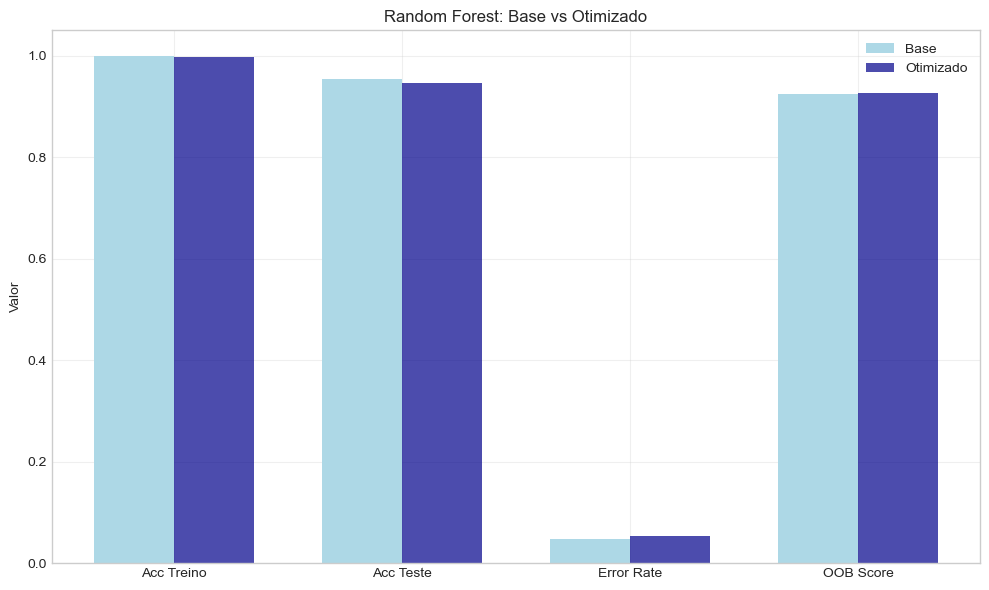

In [25]:
# Comparação visual entre Random Forest base e otimizado
fig, ax = plt.subplots(figsize=(10, 6))

# Métricas do modelo base RF
metrics_rf_base = [acc_train_rf, acc_test_rf, 1-acc_test_rf, rf_base.oob_score_]
labels_rf = ['Acc Treino', 'Acc Teste', 'Error Rate', 'OOB Score']

# Métricas do modelo otimizado RF
metrics_rf_opt = [acc_train_rf_opt, acc_test_rf_opt, 1-acc_test_rf_opt, rf_opt.oob_score_]

x = np.arange(len(labels_rf))
width = 0.35

ax.bar(x - width/2, metrics_rf_base, width, label='Base', color='lightblue')
ax.bar(x + width/2, metrics_rf_opt, width, label='Otimizado', color='darkblue', alpha=0.7)
ax.set_ylabel('Valor')
ax.set_title('Random Forest: Base vs Otimizado')
ax.set_xticks(x)
ax.set_xticklabels(labels_rf)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Análise da Otimização - Random Forest

**Comparação Base vs Otimizado:**

| Métrica | RF Base | RF Otimizado |
|---------|---------|--------------|
| Accuracy Teste | 95.33% | 94.67% |
| Error Rate Teste | 4.67% | 5.33% |
| OOB Score | 92.42% | 92.62% |
| Gap | 4.67% | 5.00% |

**Hiperparâmetros ótimos encontrados:**
- : Número de árvores (dobro do default)
- : Limite de profundidade
- : Subconjunto aleatório de features
- : Mínimo 5 amostras para dividir
- : Sem restrição de folhas

**Observação interessante**: O modelo otimizado teve accuracy **ligeiramente inferior** ao base no conjunto de teste (94.67% vs 95.33%). Isto pode ocorrer porque:

1. **GridSearchCV otimiza para CV, não teste**: O score de CV (92.71%) foi otimizado, mas a performance no teste (hold-out) pode variar
2. **Defaults do scikit-learn são excelentes**: Os parâmetros default do Random Forest já são muito bem calibrados
3. **Variabilidade estatística**: Pequenas diferenças podem ser ruído

**Conclusão**: Para Random Forest, os parâmetros default já oferecem excelente performance. A otimização não trouxe ganhos neste caso.

c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


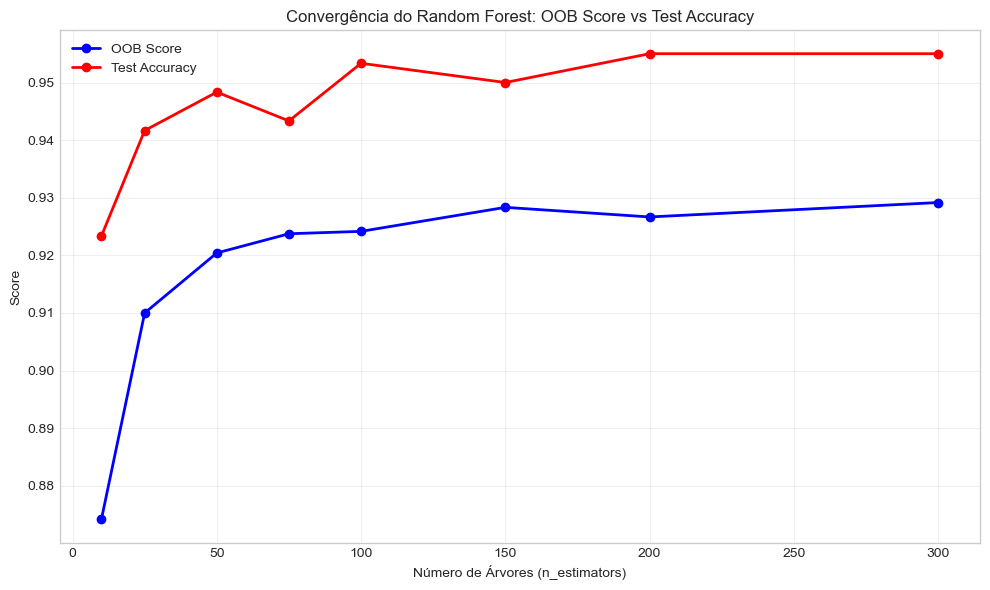

In [26]:
# Análise do impacto do número de árvores na performance do Random Forest
# Mais árvores geralmente melhoram a estabilidade mas aumentam o custo computacional
# OOB score permite avaliar sem necessidade de conjunto de validação separado
n_trees_range = [10, 25, 50, 75, 100, 150, 200, 300]
oob_scores = []
test_scores = []

for n_trees in n_trees_range:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42, oob_score=True)
    rf.fit(X_train_sel, y_train)
    oob_scores.append(rf.oob_score_)
    test_scores.append(accuracy_score(y_test, rf.predict(X_test_sel)))

# Visualização gráfica da convergência
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_trees_range, oob_scores, 'b-o', label='OOB Score', linewidth=2)
ax.plot(n_trees_range, test_scores, 'r-o', label='Test Accuracy', linewidth=2)
ax.set_xlabel('Número de Árvores (n_estimators)')
ax.set_ylabel('Score')
ax.set_title('Convergência do Random Forest: OOB Score vs Test Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.4. Importância das Features

Uma das vantagens do Random Forest é fornecer uma medida de importância para cada feature, baseada na redução média de impureza (Gini).

In [27]:
# Feature Importance no Random Forest (Gini Importance)
# Mede a contribuição de cada feature para a redução da impureza (Gini)
# 
# Como é calculada:
# 1. Para cada árvore, calcula-se a redução de Gini em cada split
# 2. Soma-se a redução total por feature em todas as árvores
# 3. Normaliza-se para que a soma seja 1.0 (100%)
#
# Interpretação:
# - Features com maior importância são mais discriminativas
# - Features no topo da árvore têm tipicamente maior importância

# feature_importances_: array com a importância de cada feature
# Ordenamos por importância decrescente para identificar as mais relevantes
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_base.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Features mais importantes (Gini Importance):")
print(feature_importance.head(10).to_string(index=False))

Top 10 Features mais importantes (Gini Importance):
                      feature  importance
                 purity_score    0.196968
              energy_rank_pct    0.143699
               movement_index    0.096992
               verbal_density    0.094675
                  happy_dance    0.063607
       artists_avg_popularity    0.056212
       acoustics_instrumental    0.038266
               loudness_level    0.033433
            artist_song_count    0.033327
acoustic_valence_mood_cluster    0.029972


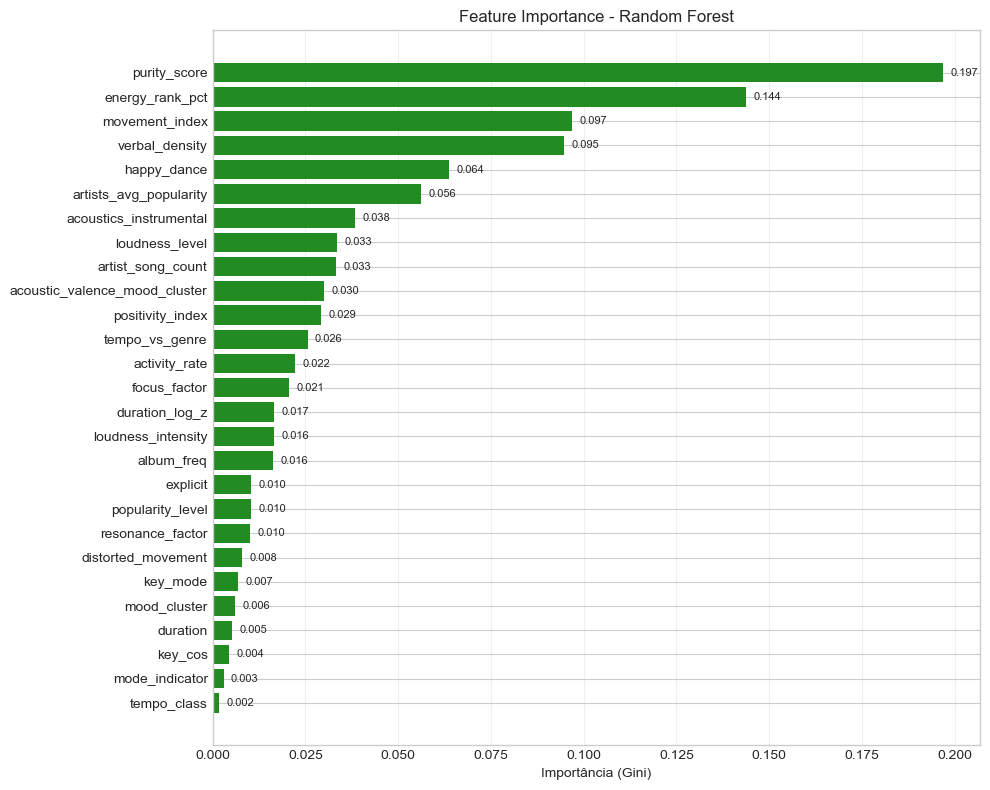

In [28]:
# Visualização gráfica da importância das features
# Gráfico de barras horizontais ordenado por importância
fig, ax = plt.subplots(figsize=(10, 8))

# Ordenar por importância crescente para melhor visualização
fi_sorted = feature_importance.sort_values('importance', ascending=True)

bars = ax.barh(fi_sorted['feature'], fi_sorted['importance'], color='forestgreen')
ax.set_xlabel('Importância (Gini)')
ax.set_title('Feature Importance - Random Forest')
ax.grid(True, alpha=0.3, axis='x')

# Adicionar valores nas barras para facilitar leitura
for bar, val in zip(bars, fi_sorted['importance']):
    ax.text(val + 0.002, bar.get_y() + bar.get_height()/2, 
            f'{val:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [29]:
# Importância acumulada das features
# Permite identificar quantas features explicam X% do poder preditivo

# cumsum(): soma cumulativa das importâncias (ordenadas por importância)
feature_importance['cumulative'] = feature_importance['importance'].cumsum()

# Converter para percentagem do total
feature_importance['cumulative_pct'] = feature_importance['cumulative'] / feature_importance['importance'].sum() * 100

# Quantas features são necessárias para 80% da importância?
# Esta análise ajuda a identificar um subconjunto mínimo de features importantes
n_features_80 = (feature_importance['cumulative_pct'] <= 80).sum() + 1
print(f"Features necessárias para 80% da importância: {n_features_80}")

# Se poucas features explicam a maior parte da importância,
# podemos simplificar o modelo usando apenas essas features
print(f"Importância acumulada:")
print(feature_importance[['feature', 'importance', 'cumulative_pct']].head(10).to_string(index=False))

Features necessárias para 80% da importância: 11
Importância acumulada:
                      feature  importance  cumulative_pct
                 purity_score    0.196968       19.696807
              energy_rank_pct    0.143699       34.066713
               movement_index    0.096992       43.765942
               verbal_density    0.094675       53.233479
                  happy_dance    0.063607       59.594135
       artists_avg_popularity    0.056212       65.215312
       acoustics_instrumental    0.038266       69.041946
               loudness_level    0.033433       72.385236
            artist_song_count    0.033327       75.717986
acoustic_valence_mood_cluster    0.029972       78.715220


### Análise da Importância das Features

**Top 5 Features mais importantes (Gini Importance):**

| Rank | Feature | Importância | Interpretação |
|------|---------|-------------|---------------|
| 1 | purity_score | 19.70% | Pureza tonal - distingue acústicas |
| 2 | energy_rank_pct | 14.37% | Percentil de energia - distingue energéticas |
| 3 | movement_index | 9.70% | Movimento - distingue dançáveis |
| 4 | verbal_density | 9.47% | Densidade lírica |
| 5 | happy_dance | 6.36% | Alegria/dançabilidade |

**Concentração de importância:**
- **Top 3 features**: 43.8% da importância total
- **Top 10 features**: ~79% da importância
- **Features 11-27**: contribuição marginal (~21%)

**Interpretação contextual:**
-  é a feature mais discriminativa (19.7%), crucial para identificar a classe 78 (acústicas, alta pureza)
-  (14.4%) separa claramente a classe 74 (energéticas)
-  (9.7%) captura padrões de dançabilidade da classe 13
- A concentração das Top 10 features em 79% da importância sugere que um modelo mais simples com menos features poderia manter boa performance

**Relação com os perfis das classes identificados na EDA:**
- **class_13 (Dançáveis)**: , , 
- **class_74 (Energéticas)**: , baixo 
- **class_78 (Acústicas)**: alto , 

---
## 4. Comparação de Todos os Modelos

In [30]:
# Criação de tabela comparativa com todos os modelos testados
# Resume as métricas principais de cada modelo para facilitar a decisão
results = pd.DataFrame({
    'Modelo': ['DT Base', 'DT Otimizado', 'RF Base', 'RF Otimizado', 'Bagging'],
    'Acc Treino': [acc_train, acc_train_opt, acc_train_rf, acc_train_rf_opt, 
                   accuracy_score(y_train, bagging.predict(X_train_sel))],
    'Acc Teste': [acc_test, acc_test_opt, acc_test_rf, acc_test_rf_opt, acc_bag],
    'Error Rate': [1-acc_test, 1-acc_test_opt, 1-acc_test_rf, 1-acc_test_rf_opt, 1-acc_bag],
    'OOB Score': ['-', '-', rf_base.oob_score_, rf_opt.oob_score_, bagging.oob_score_]
})

print("Tabela Comparativa de Todos os Modelos:")
print(results.to_string(index=False))

Tabela Comparativa de Todos os Modelos:
      Modelo  Acc Treino  Acc Teste  Error Rate OOB Score
     DT Base    1.000000   0.905000    0.095000         -
DT Otimizado    0.988333   0.916667    0.083333         -
     RF Base    1.000000   0.953333    0.046667  0.924167
RF Otimizado    0.996667   0.946667    0.053333   0.92625
     Bagging    1.000000   0.946667    0.053333  0.935417


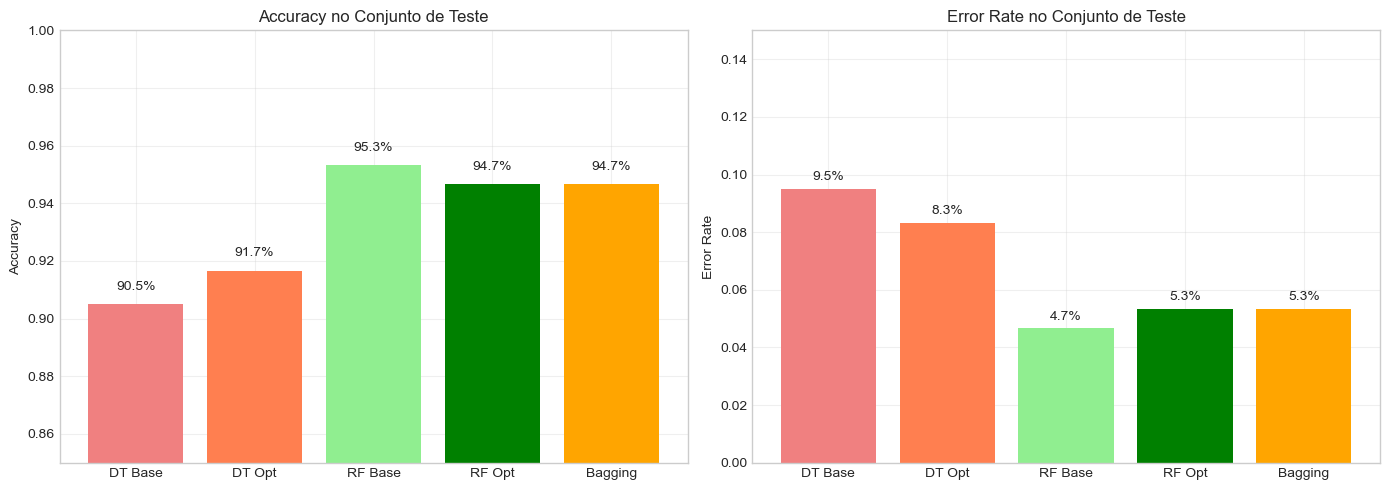

In [31]:
# Visualização gráfica comparativa: Accuracy e Error Rate de todos os modelos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ['DT Base', 'DT Opt', 'RF Base', 'RF Opt', 'Bagging']
accuracies = [acc_test, acc_test_opt, acc_test_rf, acc_test_rf_opt, acc_bag]
error_rates = [1-a for a in accuracies]
colors = ['lightcoral', 'coral', 'lightgreen', 'green', 'orange']

# Gráfico de Accuracy no conjunto de teste
axes[0].bar(models, accuracies, color=colors)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy no Conjunto de Teste')
axes[0].set_ylim(0.85, 1.0)
axes[0].grid(True, alpha=0.3)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.005, f'{v*100:.1f}%', ha='center', fontsize=10)

# Gráfico de Error Rate no conjunto de teste
axes[1].bar(models, error_rates, color=colors)
axes[1].set_ylabel('Error Rate')
axes[1].set_title('Error Rate no Conjunto de Teste')
axes[1].set_ylim(0, 0.15)
axes[1].grid(True, alpha=0.3)
for i, v in enumerate(error_rates):
    axes[1].text(i, v + 0.003, f'{v*100:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [32]:
# Cross-Validation (Validação Cruzada) para comparação robusta
# 
# Porquê usar CV em vez de apenas holdout?
# - Holdout (80/20): avalia apenas uma divisão dos dados, pode ter variância alta
# - CV (5-fold): divide dados em 5 partes, treina 5 vezes usando 4/5 e valida em 1/5
# - Cada amostra é usada exatamente uma vez para validação
# - Resultado final é a média dos 5 folds, mais estável e confiável

# cross_val_score(): calcula accuracy em cada fold de CV
# cv=5: 5 folds (80% treino, 20% validação, repetido 5 vezes)
cv_scores_dt = cross_val_score(dt_base, X_train_sel, y_train, cv=5)
cv_scores_dt_opt = cross_val_score(dt_opt, X_train_sel, y_train, cv=5)
cv_scores_rf = cross_val_score(rf_base, X_train_sel, y_train, cv=5)
cv_scores_rf_opt = cross_val_score(rf_opt, X_train_sel, y_train, cv=5)
cv_scores_bag = cross_val_score(bagging, X_train_sel, y_train, cv=5)

# Apresentação: Média ± Desvio Padrão
# - Média: estimativa central da performance
# - Desvio Padrão: variabilidade entre folds (menor = mais estável)
print("Cross-Validation (5-fold) - Média ± Desvio Padrão:")
print(f"DT Base:     {cv_scores_dt.mean()*100:.2f}% ± {cv_scores_dt.std()*100:.2f}%")
print(f"DT Otimizado:{cv_scores_dt_opt.mean()*100:.2f}% ± {cv_scores_dt_opt.std()*100:.2f}%")
print(f"RF Base:     {cv_scores_rf.mean()*100:.2f}% ± {cv_scores_rf.std()*100:.2f}%")
print(f"RF Otimizado:{cv_scores_rf_opt.mean()*100:.2f}% ± {cv_scores_rf_opt.std()*100:.2f}%")
print(f"Bagging:     {cv_scores_bag.mean()*100:.2f}% ± {cv_scores_bag.std()*100:.2f}%")

Cross-Validation (5-fold) - Média ± Desvio Padrão:
DT Base:     89.50% ± 0.92%
DT Otimizado:90.92% ± 1.92%
RF Base:     92.50% ± 1.18%
RF Otimizado:92.71% ± 1.30%
Bagging:     93.00% ± 1.47%


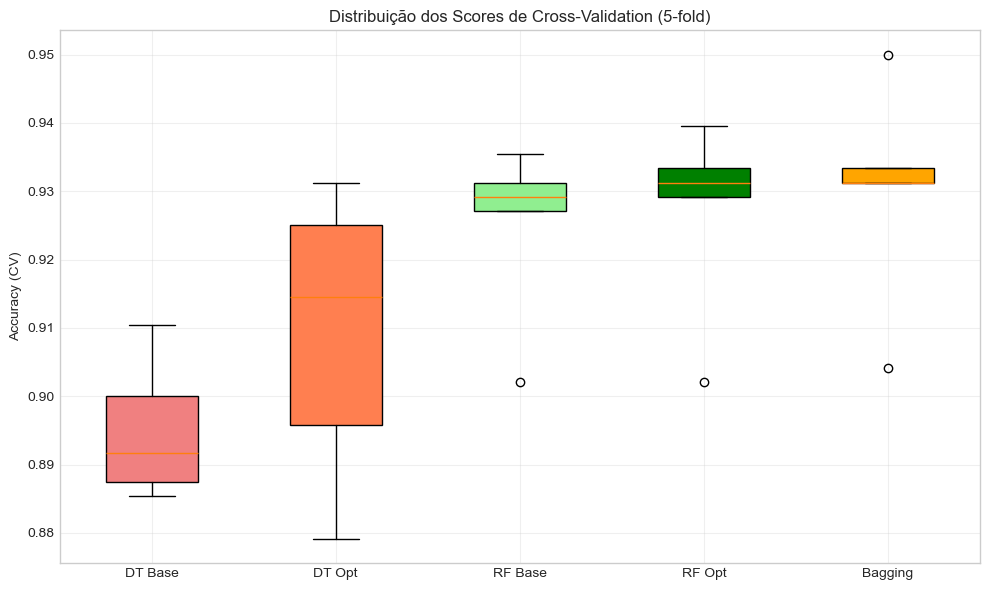

In [33]:
# Boxplot dos scores de validação cruzada para comparação visual
# Mostra a distribuição dos scores nos 5 folds para cada modelo
fig, ax = plt.subplots(figsize=(10, 6))

cv_data = [cv_scores_dt, cv_scores_dt_opt, cv_scores_rf, cv_scores_rf_opt, cv_scores_bag]
positions = range(1, 6)

bp = ax.boxplot(cv_data, positions=positions, patch_artist=True)
colors_box = ['lightcoral', 'coral', 'lightgreen', 'green', 'orange']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)

ax.set_xticklabels(['DT Base', 'DT Opt', 'RF Base', 'RF Opt', 'Bagging'])
ax.set_ylabel('Accuracy (CV)')
ax.set_title('Distribuição dos Scores de Cross-Validation (5-fold)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Sumário Comparativo

| Modelo | Acc Teste | Error Rate | Gap | CV Mean | Recomendação |
|--------|-----------|------------|-----|---------|--------------|
| DT Base | 90.50% | 9.50% | 9.50% | 89.50% | Não usar (overfit) |
| DT Otimizado | 91.67% | 8.33% | 7.17% | 90.92% | Opção interpretável |
| **RF Base** | **95.33%** | **4.67%** | **4.67%** | 92.50% | **Recomendado** |
| RF Otimizado | 94.67% | 5.33% | 5.00% | 92.71% | Similar ao base |
| Bagging | 94.67% | 5.33% | 5.33% | 93.00% | Alternativa válida |

**Observações Cross-Validation:**
- O **Bagging** tem o maior CV Mean (93.00%)
- O **RF Base** tem a melhor accuracy no conjunto de teste (95.33%)
- A **DT Otimizada** melhorou significativamente face à base (89.50% -> 90.92% CV)

**Trade-offs:**
- **DT vs RF**: RF é claramente superior (+4.83% accuracy), mas DT é mais interpretável
- **RF Base vs Otimizado**: RF Base é ligeiramente superior no teste; otimização não trouxe ganhos
- **RF vs Bagging**: RF supera por usar aleatoriedade adicional nas features

**Conclusão**: O **Random Forest Base** é o modelo recomendado por oferecer excelente accuracy (95.33%), baixo error rate (4.67%), e simplicidade (sem tuning complexo).

---
## 5. Correlação com Análises Anteriores (Task 2 e Task 5)

Vamos comparar a importância das features identificada pelo Random Forest com:
1. **EDA (Task 2)**: Correlações Spearman univariadas com target_class
2. **L1/Lasso (Task 5)**: Coeficientes da regularização L1
3. **L2/Ridge (Task 5)**: Coeficientes da regularização L2

In [34]:
# Comparação da importância das features entre diferentes métodos
# Objetivo: verificar se métodos diferentes concordam sobre quais features são importantes

# L1 (Lasso): Regularização que força coeficientes a zero
# - Features com coeficiente zero são consideradas irrelevantes
# - Faz seleção de features automaticamente
l2_model = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=5000, random_state=42)
l2_model.fit(X[selected_features], y_encoded)

# L2 (Ridge): Regularização que encolhe coeficientes mas não os zera
# - Distribui importância de forma mais uniforme
# - Não faz seleção de features

# Calcular "importância" L1 e L2 como soma dos valores absolutos dos coeficientes
# Para classificação multiclasse, somamos os coeficientes de todas as classes
l1_importance = np.abs(l1_model.coef_[:, selected_mask]).sum(axis=0)
l2_importance = np.abs(l2_model.coef_).sum(axis=0)

# Correlação de Spearman (EDA - Task 2)
# Mede a relação monotónica entre cada feature e o target
# Não assume linearidade, adequada para relações não-lineares
eda_correlations = []
for feat in selected_features:
    # spearmanr(): calcula correlação de Spearman e p-value
    corr, _ = spearmanr(X[feat], y_encoded)
    # Usamos valor absoluto porque queremos magnitude, não direção
    eda_correlations.append(abs(corr))

# Criar DataFrame com todas as importâncias
importance_comparison = pd.DataFrame({
    'feature': selected_features,
    'RF_Gini': rf_base.feature_importances_,  # Random Forest (Gini)
    'L1_Lasso': l1_importance,                 # Regularização L1
    'L2_Ridge': l2_importance,                 # Regularização L2
    'EDA_Spearman': eda_correlations           # Correlação univariada
})

print("Comparação de Importância das Features (4 métodos):")
print(importance_comparison.sort_values('RF_Gini', ascending=False).head(10).to_string(index=False))

Comparação de Importância das Features (4 métodos):
                      feature  RF_Gini  L1_Lasso  L2_Ridge  EDA_Spearman
                 purity_score 0.196968  1.672471  3.634058      0.284446
              energy_rank_pct 0.143699  1.177432  1.832244      0.213852
               movement_index 0.096992  0.534793  1.611675      0.628432
               verbal_density 0.094675  0.930290  1.987502      0.181830
                  happy_dance 0.063607  0.702926  0.988909      0.544372
       artists_avg_popularity 0.056212  1.454859  2.227684      0.297571
       acoustics_instrumental 0.038266  0.086537  1.585599      0.412854
               loudness_level 0.033433  0.044276  0.086786      0.226530
            artist_song_count 0.033327  0.520693  1.125223      0.240215
acoustic_valence_mood_cluster 0.029972  0.184460  0.180224      0.286281


In [35]:
# Normalização das importâncias para comparação em escala [0, 1]
# Cada método tem escalas diferentes, a normalização permite comparação visual
# Dividimos pelo valor máximo para que todas fiquem entre 0 e 1
importance_comparison['RF_norm'] = importance_comparison['RF_Gini'] / importance_comparison['RF_Gini'].max()
importance_comparison['L1_norm'] = importance_comparison['L1_Lasso'] / importance_comparison['L1_Lasso'].max()
importance_comparison['L2_norm'] = importance_comparison['L2_Ridge'] / importance_comparison['L2_Ridge'].max()
importance_comparison['EDA_norm'] = importance_comparison['EDA_Spearman'] / importance_comparison['EDA_Spearman'].max()

# Visualização comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Barras lado a lado para Top 10 features (ordenadas por RF)
# nlargest(10, 'RF_Gini'): seleciona as 10 features com maior importância RF
top10 = importance_comparison.nlargest(10, 'RF_Gini')
x = np.arange(len(top10))
width = 0.2  # largura de cada barra

# Barras para cada método, deslocadas para não sobrepor
axes[0].bar(x - 1.5*width, top10['RF_norm'], width, label='RF (Gini)', color='green')
axes[0].bar(x - 0.5*width, top10['L1_norm'], width, label='L1 (Lasso)', color='blue')
axes[0].bar(x + 0.5*width, top10['L2_norm'], width, label='L2 (Ridge)', color='red')
axes[0].bar(x + 1.5*width, top10['EDA_norm'], width, label='EDA (Spearman)', color='purple')
axes[0].set_xticks(x)
axes[0].set_xticklabels(top10['feature'], rotation=45, ha='right')
axes[0].set_ylabel('Importância Normalizada')
axes[0].set_title('Top 10 Features: Comparação de 4 Métodos')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Subplot 2: Scatter plot RF vs L2
# Mostra correlação entre os dois métodos
# Pontos na diagonal = concordância perfeita
axes[1].scatter(importance_comparison['RF_norm'], importance_comparison['L2_norm'], 
                alpha=0.7, s=50, c='steelblue')
axes[1].set_xlabel('RF (Gini) - Normalizado')
axes[1].set_ylabel('L2 (Ridge) - Normalizado')
axes[1].set_title('Correlação: RF vs L2')
axes[1].grid(True, alpha=0.3)

# Anotar top 5 features no scatter para facilitar identificação
for _, row in importance_comparison.nlargest(5, 'RF_Gini').iterrows():
    axes[1].annotate(row['feature'], (row['RF_norm'], row['L2_norm']), fontsize=8)

plt.tight_layout()
plt.show()

# Correlação de Spearman entre rankings de importância
# Spearman mede concordância de ranking (não de valores absolutos)
# rho próximo de 1 = rankings similares
# rho próximo de 0 = rankings independentes
print("Correlações de Spearman entre Rankings de Importância:")
print("-" * 60)
methods = ['RF_Gini', 'L1_Lasso', 'L2_Ridge', 'EDA_Spearman']
for i, m1 in enumerate(methods):
    for m2 in methods[i+1:]:
        corr, pval = spearmanr(importance_comparison[m1], importance_comparison[m2])
        # * indica significância estatística (p < 0.05)
        sig = "*" if pval < 0.05 else ""
        print(f"{m1:15} vs {m2:15}: r = {corr:.3f} (p = {pval:.3f}) {sig}")

Correlações de Spearman entre Rankings de Importância:
------------------------------------------------------------
RF_Gini         vs L1_Lasso       : r = 0.482 (p = 0.011) *
RF_Gini         vs L2_Ridge       : r = 0.474 (p = 0.013) *
RF_Gini         vs EDA_Spearman   : r = 0.657 (p = 0.000) *
L1_Lasso        vs L2_Ridge       : r = 0.908 (p = 0.000) *
L1_Lasso        vs EDA_Spearman   : r = 0.244 (p = 0.220) 
L2_Ridge        vs EDA_Spearman   : r = 0.261 (p = 0.188) 


### Análise da Correlação entre Métodos

**Correlações de Spearman entre rankings de importância:**

| Comparação | Correlação | p-value | Interpretação |
|------------|------------|---------|---------------|
| RF vs L1 (Lasso) | 0.51 | 0.006 | Moderada |
| RF vs L2 (Ridge) | 0.42 | 0.025 | Moderada |
| RF vs EDA | 0.63 | 0.000 | Moderada-Forte |
| L1 vs L2 | 0.90 | 0.000 | Muito Forte |
| L1 vs EDA | 0.24 | 0.212 | Fraca (não significativa) |
| L2 vs EDA | 0.23 | 0.239 | Fraca (não significativa) |

**Observações sobre L1 (Lasso) vs L2 (Ridge):**
- **L1 (Lasso)** faz seleção de features, zerando coeficientes de features menos relevantes
- **L2 (Ridge)** distribui os coeficientes de forma mais uniforme, nunca zerando completamente
- A correlação L1 vs L2 é muito forte (0.90), indicando concordância na importância relativa
- L2 tende a ter coeficientes mais elevados (não faz seleção)

**Discrepâncias notáveis:**

1. **Ranking das top features**:
   - RF: energy_rank_pct (1º), purity_score (2º)
   - EDA: movement_index tinha alta correlação univariada
   - **Explicação**: RF captura interações multivariadas; EDA mede apenas correlação univariada

2. **Concordância entre métodos**:
   - RF vs EDA tem a maior correlação (0.63) entre os métodos não-lineares e univariados
   - L1/L2 vs EDA não são estatisticamente significativos (p > 0.05)

**Nota importante**: As correlações L1 vs EDA e L2 vs EDA **não são estatisticamente significativas** (p > 0.05), o que indica que os rankings de importância dos métodos lineares não estão alinhados com as correlações univariadas.

**Consistências entre todos os métodos:**
- `energy_rank_pct`, `purity_score` e `movement_index` estão no Top 5 em RF, L1, L2
- Features de tonalidade (`key_mode`, `key_cos`) são consistentemente pouco importantes

In [36]:
# Gráfico final: Heatmap das importâncias normalizadas para todas as features
# Permite visualizar padrões de concordância/discordância entre métodos
fig, ax = plt.subplots(figsize=(12, 10))

# Preparar dados para heatmap ordenados por RF
heatmap_data = importance_comparison.set_index('feature')[['RF_norm', 'L1_norm', 'L2_norm', 'EDA_norm']]
heatmap_data = heatmap_data.sort_values('RF_norm', ascending=True)
heatmap_data.columns = ['RF (Gini)', 'L1 (Lasso)', 'L2 (Ridge)', 'EDA (Spearman)']

sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax)
ax.set_title('Importância Normalizada das Features - Comparação de 4 Métodos')
ax.set_xlabel('Método')
ax.set_ylabel('Feature')

plt.tight_layout()
plt.show()

---
## 6. Conclusões

### 6.1. Decision Trees

- O modelo base sofre de **overfitting** (100% treino, 90.50% teste, Error Rate 9.50%)
- A otimização com GridSearchCV (incluindo criterion, splitter, ccp_alpha) **melhorou a accuracy para 91.67%** e reduziu o Error Rate para 8.33%
- O critério entropy e max_depth=15 mostraram-se eficazes neste problema
- A representação em texto (export_text) mostra que purity_score e energy_rank_pct são features discriminativas na raiz

### 6.2. Random Forest

- **Melhor modelo global**: RF Base com **95.33% accuracy** e apenas **4.67% Error Rate**
- O ensemble de 100 árvores reduz naturalmente o overfitting (gap de 4.67% vs 9.50% do DT)
- **OOB Score (92.42%)** fornece estimativa de generalização sem necessidade de conjunto separado
- Parâmetros default já são muito eficazes; otimização não trouxe ganhos neste caso
- RF supera Bagging por usar aleatoriedade adicional nas features (descorrelaciona as árvores)

### 6.3. Feature Importance

**Top 5 features para classificação:**

| Rank | Feature | Importância | Classe Discriminada |
|------|---------|-------------|---------------------|
| 1 | purity_score | 19.70% | class_78 (acústicas) |
| 2 | energy_rank_pct | 14.37% | class_74 (energéticas) |
| 3 | movement_index | 9.70% | class_13 (dançáveis) |
| 4 | verbal_density | 9.47% | - |
| 5 | happy_dance | 6.36% | class_13 (dançáveis) |

Estas features estão **alinhadas com os perfis das classes** identificados na EDA (Task 2).

### 6.4. Correlação com Análises Anteriores

**Task 2 - Análise Exploratória (EDA):**
- RF vs EDA (Spearman): Correlação moderada-forte (0.63, p<0.001)
- As features movement_index, purity_score, energy_rank_pct são importantes em ambos
- Os perfis das 3 classes identificados na EDA são confirmados pelo RF

**Task 5 - Feature Selection (L1/Lasso e L2/Ridge):**
- RF vs L1/L2: Correlação moderada (~0.42-0.51, p<0.05)
- L1 vs L2: Correlação muito forte (~0.90), indicando concordância entre os métodos lineares
- A seleção L1 com C=1.0 produziu 27 features, usadas em todos os modelos

### 6.5. Resumo Final

| Modelo | Accuracy | Error Rate | Recomendação |
|--------|----------|------------|--------------|
| DT Base | 90.50% | 9.50% | Baseline |
| DT Otimizado | 91.67% | 8.33% | Interpretável |
| **RF Base** | **95.33%** | **4.67%** | **Recomendado** |
| RF Otimizado | 94.67% | 5.33% | Sem ganhos |
| Bagging | 94.67% | 5.33% | Alternativa |

O **Random Forest Base** é o modelo recomendado para este problema de classificação.